# Rede neural 65622 - Transformada em classificador
Melhor desempenho considerando o critério de maior cos_sim e menor loss 

In [141]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import confusion_matrix
# from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)
from scipy.stats import mode

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers
        self.drop = torch.nn.Dropout(p=0.2)
        if num_layers > 1:
            self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0], bias=False)])
            for i in range(0, self.num_layers-4):
                self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1], bias=False)])
            self.linears.append(nn.Linear(layers_size[-3], layers_size[-2], bias=True))
            self.linears.append(nn.Linear(layers_size[-2], layers_size[-1], bias=False))
            self.linears.append(nn.Linear(layers_size[-1], output_size, bias=False))
        else:
            self.linears = nn.ModuleList([nn.Linear(input_size, output_size, bias=False)])
            
        

# Última camada sem função de ativação --> sigmoide ou tanh
# ReLU em intermediárias
    def forward(self, x):
        out = list()
        out.append(x)
        m = torch.nn.Tanh()
        n = torch.nn.ReLU()
        p = torch.nn.Hardtanh()
        
        for layer in self.linears[0:-3]:
            x = m(layer(x))
            out.append(x)         
#             x = self.drop(x)
#             x = x/(torch.sum(x,dim=1, keepdim=True)+1e-6)
        x = (self.linears[-3](x))
        out.append(x)         
        x = n(self.linears[-2](x))
        out.append(x)         
        x = (self.linears[-1](x))
        out.append(x)
#         x = n(x)
        return out

# # Aplicando função de ativação na última camada tbm
# ### Tentar mudar pra sigmoide se deixar a normalização de 0,1
#     def forward(self, x):
#         for layer in self.linears:                   
#             x = torch.tanh(layer(x))
#         return(x)

In [3]:
def nonRepeatedRandomInt(low, upper, N):
        import numpy as np
        import random
        
        numbers = np.arange(low, upper, 1)
        random.shuffle(numbers)
        shuffleNumbers = np.array(numbers)[0:int(N)]
                
        return shuffleNumbers

In [4]:
def createSurrogate(X):
    Xsur  = np.zeros_like(X)
    for i in range(X.shape[1]):
        Xsur[:,i] = X[nonRepeatedRandomInt(0, X.shape[0], X.shape[0]),i]
    return Xsur

In [5]:
import shutil
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    
    if is_best:
        torch.save(state, filename)
#         shutil.copyfile(filename, 'model_best.pth.tar')
#         print('*****Saved epoch: %d *****' % (state['epoch']))

In [6]:
def ls(p,y):
    M = np.shape(p)[1]
    beta = np.empty((M))
    py = np.transpose(p).dot(y)
    covP = np.linalg.inv(np.transpose(p).dot(p))
    beta =  covP.dot(py)
    return beta

In [7]:
# Sorteando quais caracteristicas usar
data = pd.read_pickle("../Data_prep/data_closed_rigid_o")
data['Corrective lens_total'] = data['Corrective lens'].sum(axis=1)
data.drop('Corrective lens', axis='columns', inplace=True)
data['Hearing'] = data['Hearing_total'].sum(axis=1)
data.drop('Hearing_total', axis='columns', inplace=True)
data['Normal Shoes_total'] = np.clip(data['Normal Shoes_total'].values, 0, 1)
data['Dental_total'] = np.clip(data['Dental_total'].values, 0, 1)
data['Hearing'] = np.clip(data['Hearing'].values, 0, 1)
data['Ortho-Prosthesis'] = data['Ortho-Prosthesis'].astype(float)
data['AgeGroup'] = data['AgeGroup'].astype(float)
data['Illness'] = data['Illness'].astype(float)
data['Gender'] = data['Gender'].astype(float)
data['Disability'] = data['Disability'].astype(float)

In [8]:
data = data[data.columns[data.sum(axis=0)>0.05*len(data)]]
pf50 = np.round(data["PF50_closed_rigid"].values, 2)

features = data.copy()
features.drop("PF50_closed_rigid", axis=1, inplace=True)
# features2 = features.loc[:,['Age', 'Height', 'Weight','BMI','FootLen',
#                             'Ystudy','Nmedication']].copy()

# features2.iloc[:,:] = features2.values**3
# features2.columns = features2.columns + '2' 
# features = pd.concat((features, features2), join='outer', axis=1)
features_names = features.columns
# featToRemove = np.logical_and()


print('Features: ',list(features_names))
X = features.values.astype('float')
y = pf50.reshape(len(data), 1)

# feat = np.hstack((features.columns, np.array(['1']).reshape(1)))

Features:  ['Age', 'AgeGroup', 'Gender', 'Height', 'Weight', 'BMI', 'FootLen', 'Ystudy', 'Illness', 'Nmedication', 'Ortho-Prosthesis', 'Disability', 'Falls12m', 'AngiotensinIIreceptorantagonist', 'Betablocker', 'Biguanide', 'Bisphosphonate', 'Diuretic', 'HMGCoAreductaseinhibitor', 'Oralcontraceptive', 'Syntheticthyroidhormone', 'Osteopenia_total', 'Arthrosis_total', 'Hypercholesterolemia_total', 'Diabetes mellitus_total', 'Hypertension_total', 'Hypothyroidism_total', 'Labyrinthitis_total', 'Osteoporosis_total', 'Rhinitis_total', 'Normal Shoes_total', 'Sandal_FlipFlop_total', 'Dental_total', 'Corrective lens_total', 'Hearing']


In [9]:
# import sys
# sys.path.insert(1, '/home/rnwatanabe/Dropbox/Nonlinear-System-Identification-and-Frequency-Analysis/')
# import identFunctions

# featuresChosen, featuresChosenNames = identFunctions.selectFeatures(X_train_scaled, y_train_scaled,
#                                                                     featureNames=feat, pho=0.01, L=1,
#                                                                     mfrolsEngine='python', verb)


# print(featuresChosenNames)
# X = X[:, featuresChosen]
X.shape

(207, 35)

In [153]:
nets = dict()
Nnets = 2000
random_state = 94897# np.random.randint(0, Nnets*10, 1)[0]
X_trainTemp, X_test, y_trainTemp, y_test = train_test_split(X, y, test_size=0.4)

scaler_x = RobustScaler(with_centering=True)
X_trainTemp_scaled = scaler_x.fit_transform(X_trainTemp)
X_trainTemp_scaled = np.hstack((X_trainTemp_scaled, np.ones((len(X_trainTemp_scaled),1))))

# Precisa da normalização do y?
scaler_y = RobustScaler(with_centering=True)
y_trainTemp_scaled = scaler_y.fit_transform(y_trainTemp).reshape(-1,1)

# Transformando o dado de validação

X_test_scaled = scaler_x.transform(X_test)
X_test_scaled = np.hstack((X_test_scaled, np.ones((len(X_test_scaled),1))))
y_test_scaled = scaler_y.transform(y_test).reshape(-1,1)



np.save('X_trainVali', X_trainTemp)
np.save('X_test', X_test)
np.save('y_trainVali', y_trainTemp)
np.save('y_test', y_test)


X = np.hstack((X, np.ones((len(X),1))))
best_loss = 100*np.ones(Nnets)
best_loss_sur = 100*np.ones(Nnets)
best_acc = np.zeros(Nnets)
best_acc_sur = np.zeros(Nnets)
best_r = -100*np.ones(Nnets)
best_r_sur = -100*np.ones(Nnets)
best_diffsd = 100*np.ones(Nnets)
best_diffsd_sur = 100*np.ones(Nnets)
CM = 100*np.ones((4,4,Nnets))


TypeError: Cannot interpret '4' as a data type

In [122]:
for i in range(Nnets):
    print('Net', i)
    random_state = np.random.randint(0, Nnets*10, 1)[0]    
    X_vali_scaled, X_train_scaled, y_vali_scaled, y_train_scaled = train_test_split(X_trainTemp_scaled, y_trainTemp_scaled, test_size=0.75, 
                                                            random_state=random_state)

    X_vali_scaled_sur = createSurrogate(X_vali_scaled)
    X_test_scaled_sur = createSurrogate(X_test_scaled)

    criterion = nn.CosineSimilarity(dim=0)   
    
    num_layers = np.random.randint(4, 5, 1)[0]
#     num_layers = 4
#     print('Number of layers: %d' % (num_layers))
    layer_init_size = np.random.randint(5, 20, 1)[0]
#     print('Inicial size layer: %d' % (layer_init_size))
    layers_size = np.linspace(layer_init_size, 1, num_layers-1, dtype=int)
    layers_size[-1] = 2
    layers_size[-2] = 1
#     num_layers = 2
#     # layers_size[4] = 5
#     layers_size = np.zeros((num_layers-1), dtype=int)
#     layers_size[0] = 3
#     # layers_size[1] = 3
#     # layers_size[2] = 4
# #     layers_size[1] = 1
# #     layers_size[2] = 2
    
#     # layers_size[3] = 6
    print(X.shape)
    nets[i] = Net(input_size=X.shape[1], num_layers=num_layers, layers_size=layers_size, 
                  output_size=1)
    optimizer = torch.optim.SGD(nets[i].parameters(), lr = 0.0001) # lr = learning rate 

    epochs = 30000
    loss_train = np.zeros(epochs)
    acc_train = np.zeros(epochs)
    loss_vali = np.zeros(epochs)
    loss_vali_sur = np.zeros(epochs)
    acc_vali = np.zeros(epochs)
    acc_vali_sur = np.zeros(epochs)
    nets[i].linears[-3].bias.requires_grad_(False)
    nets[i].linears[-3].bias[0] = 0
    print(nets[i].linears[-3].bias)
    for epoch in range(epochs):
        nets[i].train()
        
        inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
        targets = torch.autograd.Variable(torch.Tensor(y_train_scaled.astype(np.float32).squeeze(1)).float())

        optimizer.zero_grad()
        out = nets[i](inputs)[-3]
        
        
        loss = 1 - criterion(out.squeeze(), targets.squeeze())
    #     loss = lossDist(out.squeeze(), targets, hist, bins)
        loss.backward()
        optimizer.step()

        loss_train[epoch] = loss.item()

        
        
        # Validação
        if (epoch + 1) % 10 == 0:
            nets[i].eval()
            inputs_vali = torch.autograd.Variable(torch.Tensor(X_vali_scaled.astype(np.float32)).float())
            targets_vali = torch.autograd.Variable(torch.Tensor(y_vali_scaled.astype(np.float32).squeeze()).float())
            out_vali = nets[i](inputs_vali)[-3]
            loss_v = 1 - criterion(out_vali.squeeze(), targets_vali.squeeze())
    #         loss_v = lossDist(out_vali.squeeze(), targets_vali, hist, bins)
            loss_vali[epoch] = loss_v.item()

            # predicted = out.data
            _, predicted = torch.max(out_vali.data, 1) # Usar dessa forma?

            # Calcula acurácia
            error_count = y_vali_scaled.size - np.count_nonzero((targets_vali.squeeze() == predicted).numpy())
            
            classTarget = np.digitize(targets_vali, np.quantile(y_train_scaled,[0.25,0.5,0.75])) 
            classOut = np.digitize(out_vali.detach().numpy(), np.quantile(y_train_scaled,[0.25,0.5,0.75]))
            # remember best loss and save checkpoint
            # Trocar critério de melhor rede para a que tem melhor acurácia
            acc_vali[epoch] = 100 * np.sum(classTarget.squeeze() == classOut.squeeze()) // y_vali_scaled.size
            
            r_vali = np.corrcoef(out_vali.detach().numpy().squeeze(), targets_vali.detach().numpy().squeeze())[0,1]
            is_best = loss_vali[epoch]< best_loss[i]
            if is_best:
                best_loss[i] = loss_vali[epoch]
                best_acc[i] = acc_vali[epoch]
                best_r[i] = np.corrcoef(out_vali.detach().numpy().squeeze(), targets_vali.detach().numpy().squeeze())[0,1]
            
            save_checkpoint({'epoch': epoch + 1,
                            #'arch': args.arch,
                            'state_dict': nets[i].state_dict(),
                            'best_loss': best_r,
                            'optimizer' : optimizer.state_dict(),
                            }, is_best, filename='./nets/net'+str(i)+'_2.pth.tar')
            
            if is_best:                
                inputs_vali_sur = torch.autograd.Variable(torch.Tensor(X_vali_scaled_sur.astype(np.float32)).float())
                targets_vali_sur = torch.autograd.Variable(torch.Tensor(y_vali_scaled.astype(np.float32).squeeze()).float())
                out_vali_sur = nets[i](inputs_vali_sur)[-3]
                loss_v = 1 - criterion(out_vali_sur.squeeze(), targets_vali_sur.squeeze())
        #         loss_v = lossDist(out_vali.squeeze(), targets_vali, hist, bins)
                loss_vali_sur[epoch] = loss_v.item()

                # predicted = out.data
                

                
#                 best_r_sur[i] = np.corrcoef(out_vali_sur.detach().numpy().squeeze(), targets_vali_sur.detach().numpy().squeeze())[0,1]
#                 best_loss_sur[i] = loss_vali_sur[epoch]
#                 # print('Net', i)   
#                 # print('epoch', epoch)
#                 # print('R',best_r[i])
#                 # print('R surrogate', best_r_sur[i], '\n')



    if best_loss[i] < 100:
      checkpoint = torch.load('./nets/net'+str(i)+'_2.pth.tar')
      nets[i].load_state_dict(checkpoint['state_dict'])
      nets[i].linears[-3].bias[0] = 0
      optimizer.zero_grad()
      inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
      targets = torch.autograd.Variable(torch.Tensor(y_train_scaled.astype(np.float32).squeeze(1)).float())
      out = nets[i](torch.cat((inputs, inputs_vali), dim=0))[-3]
      for j in range(len(nets[i].linears)-2):
          nets[i].linears[j].weight.requires_grad_(False)
      nets[i].linears[-1].weight[0,0] = 1
      nets[i].linears[-1].weight[0,1] = -1
      nets[i].linears[-3].bias[0] = -(torch.median(out)-0*torch.median(torch.cat((targets, targets_vali), dim=0)))
      nets[i].linears[-2].weight[0,0] = np.quantile(torch.cat((targets, targets_vali), dim=0).detach().numpy(), 0.75)/np.quantile((out+nets[i].linears[-3].bias[0]).detach().numpy(), 0.75)
      nets[i].linears[-2].weight[1,0] = -np.quantile(torch.cat((targets, targets_vali), dim=0).detach().numpy(), 0.25)/np.quantile((out+nets[i].linears[-3].bias[0]).detach().numpy(), 0.25)
      print(nets[i].linears[-2].weight[1,0]) 
      print(nets[i].linears[-3].bias[0])
      print('median out', torch.median(out))
      print('median target', torch.median(torch.cat((targets, targets_vali), dim=0)))
      print('0.2 quant', np.quantile(torch.cat((targets, targets_vali), dim=0).detach().numpy(), 0.2))
      print('0.2 quant out', np.quantile((out+nets[i].linears[-3].bias[0]).detach().numpy(), 0.2))
      print('loss',best_loss[i])
      print('loss surrogate', best_loss_sur[i])
      out_vali_sur = nets[i](inputs_vali_sur)[-3]
      out_vali = nets[i](inputs_vali)[-3]
      best_loss[i] = 1 - criterion(out_vali.squeeze(), targets_vali.squeeze())
      classTarget = np.digitize(targets_vali, np.quantile(y_train_scaled,[0.25,0.5,0.75])) 
      classOut = np.digitize(out_vali.detach().numpy(), np.quantile(y_train_scaled,[0.25,0.5,0.75]))
      # remember best loss and save checkpoint
      # Trocar critério de melhor rede para a que tem melhor acurácia
      best_acc[i] = 100 * np.sum(classTarget.squeeze() == classOut.squeeze()) // y_vali_scaled.size
      best_r[i] = np.corrcoef(out_vali.detach().numpy().squeeze(), targets_vali.detach().numpy().squeeze())[0,1]
      best_loss_sur[i] = 1 - criterion(out_vali_sur.squeeze(), targets_vali_sur.squeeze())
      print('acc',best_acc[i])
      print('loss',best_loss[i])
      print('loss surrogate', best_loss_sur[i], '\n')
      CM[:,:,,i] = confu  
    
    
      save_checkpoint({'epoch': epoch + 1,
                       #'arch': args.arch,
                       'state_dict': nets[i].state_dict(),
                       'best_loss': best_r,
                        'optimizer' : optimizer.state_dict(),
                       }, True, filename='./nets/net'+str(i)+'_2.pth.tar')   
#     optimizer = torch.optim.SGD(nets[i].parameters(), lr = 0.005) # lr = learning rate 
#     epochs = 30000
#     loss_train = np.zeros(epochs)
#     acc_train = np.zeros(epochs)
#     loss_vali = np.zeros(epochs)
#     acc_vali = np.zeros(epochs)
#     best_loss = 100
#     best_acc = 0
#     criterion2 = nn.MSELoss()

#     for epoch in range(epochs):
#         nets[i].train()    
#         inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
#         targets = torch.autograd.Variable(torch.Tensor(y_train_scaled.astype(np.float32).squeeze()).float())

#         optimizer.zero_grad()
#         out = nets[i](inputs)[-1]

#         loss = criterion2(out.squeeze(), targets.squeeze())
#         loss.backward()
#         optimizer.step()

#         loss_train[epoch] = loss.item()

#         _, predicted_train = torch.max(out.data, 1) # Usar dessa forma?
#         acc_train[epoch] = 100 * torch.sum(targets.squeeze() == predicted_train) / y_train_scaled.size
#         # Validação
#         if (epoch + 1) % 10 == 0:
#             nets[i].eval()
#             inputs_vali = torch.autograd.Variable(torch.Tensor(X_vali_scaled.astype(np.float32)).float())
#             targets_vali = torch.autograd.Variable(torch.Tensor(y_vali_scaled.astype(np.float32).squeeze()).float())
#             out_vali = nets[i](inputs_vali)[-1]
#             loss_v = criterion2(out_vali.squeeze(), targets_vali.squeeze()) + torch.var(out_vali - targets_vali)
#     #         loss_v = lossDist(out_vali.squeeze(), targets_vali, hist, bins)
#             loss_vali[epoch] = loss_v.item()

#             # predicted = out.data
#             _, predicted = torch.max(out_vali.data, 1) # Usar dessa forma?

#             # Calcula acurácia
#             error_count = y_vali_scaled.size - np.count_nonzero((targets_vali.squeeze() == predicted).numpy())

#             # remember best loss and save checkpoint
#             # Trocar critério de melhor rede para a que tem melhor acurácia
#             acc_vali[epoch] = 100 * torch.sum(targets_vali.squeeze() == predicted) / y_vali_scaled.size
#             diffsd_vali = np.std((out_vali.detach().numpy() - targets_vali.detach().numpy()))
#             is_best = diffsd_vali < best_diffsd[i]
#             best_diffsd[i] = min(diffsd_vali, best_diffsd[i])
# #             is_best = loss_vali[epoch] < best_loss
# #             best_loss = min(loss_vali[epoch], best_loss)
#             save_checkpoint({
#             'epoch': epoch + 1,
#             #'arch': args.arch,
#             'state_dict': nets[i].state_dict(),
#             'best_loss': best_loss,
#             'optimizer' : optimizer.state_dict(),
#             }, is_best)
            
#             if is_best:
                
#                 inputs_vali = torch.autograd.Variable(torch.Tensor(X_vali_scaled_sur.astype(np.float32)).float())
#                 targets_vali = torch.autograd.Variable(torch.Tensor(y_vali_scaled.astype(np.float32).squeeze()).float())
#                 out_vali = nets[i](inputs_vali)[-1]
#                 loss_v = criterion2(out_vali.squeeze(), targets_vali.squeeze())+torch.var(out_vali - targets_vali)
#         #         loss_v = lossDist(out_vali.squeeze(), targets_vali, hist, bins)
#                 loss_vali_sur[epoch] = loss_v.item()

#                 # predicted = out.data
#                 _, predicted = torch.max(out_vali.data, 1) # Usar dessa forma?

#                 # Calcula acurácia
#                 error_count = y_vali_scaled.size - np.count_nonzero((targets_vali.squeeze() == predicted).numpy())

#                 classTarget = np.digitize(targets_vali, np.quantile(y_train_scaled,[0.25,0.5,0.75])) 
#                 classOut = np.digitize(out_vali.detach().numpy(), np.quantile(y_train_scaled,[0.25,0.5,0.75]))
#                 # remember best loss and save checkpoint
#                 # Trocar critério de melhor rede para a que tem melhor acurácia
#                 acc_vali_sur[epoch] = 100 * np.sum(classTarget.squeeze() == classOut.squeeze()) / y_vali.size

                
                
#                 best_diffsd_sur[i] = np.std((out_vali.detach().numpy() - targets_vali.detach().numpy()))

#                 print('Net', i)   
#                 print('epoch', epoch)
#                 print('SD',best_diffsd[i])
#                 print('SD surrogate', best_diffsd_sur[i], '\n')

            
#     checkpoint = torch.load('checkpoint.pth.tar')
#     nets[i].load_state_dict(checkpoint['state_dict'])
#     optimizer.zero_grad()      





Net 0
tensor(-5.0001, grad_fn=<SelectBackward>)
tensor(-0.0602, grad_fn=<SelectBackward>)
median out tensor(0.0602, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10536794066429139
loss 0.45381903648376465
loss surrogate 0.949508786201477
acc 22.0
loss 0.45666253566741943
loss surrogate 0.9676000475883484 

Net 1
tensor(-5.6652, grad_fn=<SelectBackward>)
tensor(-0.0629, grad_fn=<SelectBackward>)
median out tensor(0.0629, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0972863644361496
loss 0.6126810312271118
loss surrogate 0.9732154607772827
acc 25.0
loss 0.5103315114974976
loss surrogate 0.8231229782104492 

Net 2
tensor(-5.2256, grad_fn=<SelectBackward>)
tensor(-0.0497, grad_fn=<SelectBackward>)
median out tensor(0.0497, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09383777529001236
loss 0.6756880879402161
loss surrogate 0.904585

loss 0.5068098902702332
loss surrogate 0.7299526929855347
acc 22.0
loss 0.4425128698348999
loss surrogate 0.8843507766723633 

Net 25
tensor(-6.3486, grad_fn=<SelectBackward>)
tensor(-0.0374, grad_fn=<SelectBackward>)
median out tensor(0.0374, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0779642730951309
loss 0.6744908094406128
loss surrogate 0.9121075868606567
acc 22.0
loss 0.39444243907928467
loss surrogate 1.1020069122314453 

Net 26
tensor(-3.9125, grad_fn=<SelectBackward>)
tensor(-0.0513, grad_fn=<SelectBackward>)
median out tensor(0.0513, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.13174449801445007
loss 0.5838266611099243
loss surrogate 1.0263895988464355
acc 19.0
loss 0.51801598072052
loss surrogate 0.8250797986984253 

Net 27
tensor(-3.1637, grad_fn=<SelectBackward>)
tensor(-0.1313, grad_fn=<SelectBackward>)
median out tensor(0.1313, grad_fn=<MedianBackward0>)
median ta

tensor(-3.0457, grad_fn=<SelectBackward>)
tensor(-0.0789, grad_fn=<SelectBackward>)
median out tensor(0.0789, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.15839883983135222
loss 0.7143892049789429
loss surrogate 1.09666907787323
acc 19.0
loss 0.5269373655319214
loss surrogate 0.7820272445678711 

Net 53
tensor(-6.3166, grad_fn=<SelectBackward>)
tensor(-0.0262, grad_fn=<SelectBackward>)
median out tensor(0.0262, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0889974743127823
loss 0.4384889602661133
loss surrogate 0.755538821220398
acc 19.0
loss 0.4563807249069214
loss surrogate 0.877029538154602 

Net 54
tensor(-3.7686, grad_fn=<SelectBackward>)
tensor(-0.0746, grad_fn=<SelectBackward>)
median out tensor(0.0746, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12890192568302156
loss 0.35569632053375244
loss surrogate 1.18467140197753

tensor(-6.9100, grad_fn=<SelectBackward>)
tensor(-0.0444, grad_fn=<SelectBackward>)
median out tensor(0.0444, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07670170366764067
loss 0.5458501577377319
loss surrogate 0.9287151098251343
acc 22.0
loss 0.3214145302772522
loss surrogate 0.9345371723175049 

Net 85
tensor(-6.0382, grad_fn=<SelectBackward>)
tensor(-0.0667, grad_fn=<SelectBackward>)
median out tensor(0.0667, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08794771879911423
loss 0.5345017910003662
loss surrogate 0.759112536907196
acc 25.0
loss 0.4882352948188782
loss surrogate 0.7978787422180176 

Net 86
tensor(-4.1468, grad_fn=<SelectBackward>)
tensor(-0.0518, grad_fn=<SelectBackward>)
median out tensor(0.0518, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11762498170137406
loss 0.46133142709732056
loss surrogate 0.7626336216

tensor(-7.6777, grad_fn=<SelectBackward>)
tensor(-0.0448, grad_fn=<SelectBackward>)
median out tensor(0.0448, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07122312784194945
loss 0.6319708824157715
loss surrogate 0.7332576513290405
acc 22.0
loss 0.45373594760894775
loss surrogate 0.959852933883667 

Net 109
tensor(-4.9709, grad_fn=<SelectBackward>)
tensor(-0.0179, grad_fn=<SelectBackward>)
median out tensor(0.0179, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10842900276184082
loss 0.4815934896469116
loss surrogate 1.042615294456482
acc 22.0
loss 0.37645381689071655
loss surrogate 0.6928391456604004 

Net 110
tensor(-6.8294, grad_fn=<SelectBackward>)
tensor(-0.0824, grad_fn=<SelectBackward>)
median out tensor(0.0824, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09045717120170593
loss 0.6144267916679382
loss surrogate 0.68708121

tensor(-0.0260, grad_fn=<SelectBackward>)
median out tensor(0.0260, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08919875919818877
loss 0.5441582202911377
loss surrogate 0.8106316924095154
acc 25.0
loss 0.3613808751106262
loss surrogate 0.8990827798843384 

Net 142
tensor(-5.1229, grad_fn=<SelectBackward>)
tensor(-0.0202, grad_fn=<SelectBackward>)
median out tensor(0.0202, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1259016007184982
loss 0.46728283166885376
loss surrogate 0.7882702946662903
acc 29.0
loss 0.47793906927108765
loss surrogate 0.928436815738678 

Net 143
tensor(-4.0147, grad_fn=<SelectBackward>)
tensor(-0.0332, grad_fn=<SelectBackward>)
median out tensor(0.0332, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1523563116788864
loss 0.5056288242340088
loss surrogate 0.7234625816345215
acc 16.0
loss 0.4592684507369995
l

tensor(-4.9914, grad_fn=<SelectBackward>)
tensor(-0.0578, grad_fn=<SelectBackward>)
median out tensor(0.0578, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1141665905714035
loss 0.5957829356193542
loss surrogate 0.9626918435096741
acc 19.0
loss 0.4468175768852234
loss surrogate 0.7630404829978943 

Net 169
tensor(-4.5365, grad_fn=<SelectBackward>)
tensor(-0.0731, grad_fn=<SelectBackward>)
median out tensor(0.0731, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1147117957472801
loss 0.5224064588546753
loss surrogate 0.6627640724182129
acc 16.0
loss 0.5677627325057983
loss surrogate 1.0304661989212036 

Net 170
tensor(-4.5304, grad_fn=<SelectBackward>)
tensor(-0.0638, grad_fn=<SelectBackward>)
median out tensor(0.0638, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11050800234079361
loss 0.6491671800613403
loss surrogate 1.0331541299

tensor(-5.4373, grad_fn=<SelectBackward>)
tensor(-0.0302, grad_fn=<SelectBackward>)
median out tensor(0.0302, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10350216031074524
loss 0.5826062560081482
loss surrogate 0.8872299194335938
acc 25.0
loss 0.4157819151878357
loss surrogate 0.8445516228675842 

Net 196
tensor(-4.8630, grad_fn=<SelectBackward>)
tensor(-0.0541, grad_fn=<SelectBackward>)
median out tensor(0.0541, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1059827834367752
loss 0.6795985698699951
loss surrogate 0.9672808647155762
acc 29.0
loss 0.47860002517700195
loss surrogate 0.9899395704269409 

Net 197
tensor(-7.3745, grad_fn=<SelectBackward>)
tensor(-0.0311, grad_fn=<SelectBackward>)
median out tensor(0.0311, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07752758115530013
loss 0.4066181182861328
loss surrogate 0.59919047

tensor(-3.6171, grad_fn=<SelectBackward>)
tensor(-0.0707, grad_fn=<SelectBackward>)
median out tensor(0.0707, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.15330090522766113
loss 0.4997985363006592
loss surrogate 0.7475240230560303
acc 25.0
loss 0.4453805088996887
loss surrogate 0.7526628971099854 

Net 223
tensor(-3.5721, grad_fn=<SelectBackward>)
tensor(-0.0726, grad_fn=<SelectBackward>)
median out tensor(0.0726, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1370251417160034
loss 0.5470340251922607
loss surrogate 1.0199824571609497
acc 22.0
loss 0.4393365979194641
loss surrogate 0.8723884224891663 

Net 224
tensor(-2.9082, grad_fn=<SelectBackward>)
tensor(-0.0704, grad_fn=<SelectBackward>)
median out tensor(0.0704, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.17082347869873046
loss 0.4269641637802124
loss surrogate 0.974224984

tensor(-4.4112, grad_fn=<SelectBackward>)
tensor(-0.0562, grad_fn=<SelectBackward>)
median out tensor(0.0562, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11721585243940352
loss 0.5273299217224121
loss surrogate 0.9955670237541199
acc 25.0
loss 0.4432315230369568
loss surrogate 0.9019970893859863 

Net 250
tensor(-2.7697, grad_fn=<SelectBackward>)
tensor(-0.1271, grad_fn=<SelectBackward>)
median out tensor(0.1271, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1893168061971664
loss 0.9472103714942932
loss surrogate 0.9963162541389465
acc 29.0
loss 0.5106639862060547
loss surrogate 1.0329818725585938 

Net 251
tensor(-6.7535, grad_fn=<SelectBackward>)
tensor(-0.1134, grad_fn=<SelectBackward>)
median out tensor(0.1134, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08955727666616439
loss 0.48661184310913086
loss surrogate 0.71360111

tensor(-3.8329, grad_fn=<SelectBackward>)
tensor(-0.0824, grad_fn=<SelectBackward>)
median out tensor(0.0824, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.13558100461959838
loss 0.6247788071632385
loss surrogate 0.7581596374511719
acc 25.0
loss 0.6333988308906555
loss surrogate 0.84182208776474 

Net 277
tensor(-1.8829, grad_fn=<SelectBackward>)
tensor(-0.1987, grad_fn=<SelectBackward>)
median out tensor(0.1987, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.25600568652153016
loss 0.49006175994873047
loss surrogate 0.9600532054901123
acc 22.0
loss 0.6505143642425537
loss surrogate 0.913923978805542 

Net 278
tensor(-4.4276, grad_fn=<SelectBackward>)
tensor(-0.1420, grad_fn=<SelectBackward>)
median out tensor(0.1420, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1151113212108612
loss 0.6626458168029785
loss surrogate 0.78592258691

tensor(-4.5004, grad_fn=<SelectBackward>)
tensor(-0.0651, grad_fn=<SelectBackward>)
median out tensor(0.0651, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11332636177539826
loss 0.8763560652732849
loss surrogate 1.192461609840393
acc 22.0
loss 0.5276696681976318
loss surrogate 1.03538978099823 

Net 300
tensor(-2.8477, grad_fn=<SelectBackward>)
tensor(-0.1136, grad_fn=<SelectBackward>)
median out tensor(0.1136, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.19909344315528868
loss 0.5875787734985352
loss surrogate 1.2071750164031982
acc 25.0
loss 0.4529338479042053
loss surrogate 0.8693593740463257 

Net 301
tensor(-6.7113, grad_fn=<SelectBackward>)
tensor(-0.0087, grad_fn=<SelectBackward>)
median out tensor(0.0087, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0711271345615387
loss 0.3821223974227905
loss surrogate 0.760273933410

tensor(-4.7544, grad_fn=<SelectBackward>)
tensor(-0.0427, grad_fn=<SelectBackward>)
median out tensor(0.0427, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1070910707116127
loss 0.39626646041870117
loss surrogate 0.9960172772407532
acc 19.0
loss 0.41132551431655884
loss surrogate 1.0448617935180664 

Net 333
tensor(-4.6565, grad_fn=<SelectBackward>)
tensor(-0.0701, grad_fn=<SelectBackward>)
median out tensor(0.0701, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11756139695644377
loss 0.5077807903289795
loss surrogate 0.6019806861877441
acc 22.0
loss 0.38338083028793335
loss surrogate 0.8714428544044495 

Net 334
tensor(-2.8304, grad_fn=<SelectBackward>)
tensor(-0.0971, grad_fn=<SelectBackward>)
median out tensor(0.0971, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.17072484493255616
loss 0.6007845997810364
loss surrogate 1.030459

acc 29.0
loss 0.4181292653083801
loss surrogate 0.8197606801986694 

Net 365
tensor(-4.4836, grad_fn=<SelectBackward>)
tensor(-0.0967, grad_fn=<SelectBackward>)
median out tensor(0.0967, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.13655520677566527
loss 0.7633332014083862
loss surrogate 0.7047016024589539
acc 25.0
loss 0.47736310958862305
loss surrogate 0.7910752296447754 

Net 366
tensor(-4.7115, grad_fn=<SelectBackward>)
tensor(-0.0634, grad_fn=<SelectBackward>)
median out tensor(0.0634, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1154705062508583
loss 0.6427968144416809
loss surrogate 0.9309130907058716
acc 19.0
loss 0.5392513871192932
loss surrogate 0.6928268671035767 

Net 367
tensor(-9.6816, grad_fn=<SelectBackward>)
tensor(-0.0375, grad_fn=<SelectBackward>)
median out tensor(0.0375, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 qua

tensor(-4.1461, grad_fn=<SelectBackward>)
tensor(-0.0589, grad_fn=<SelectBackward>)
median out tensor(0.0589, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1178312748670578
loss 0.5388562679290771
loss surrogate 1.0657750368118286
acc 22.0
loss 0.5903027057647705
loss surrogate 0.9718098044395447 

Net 390
tensor(-7.0999, grad_fn=<SelectBackward>)
tensor(-0.0314, grad_fn=<SelectBackward>)
median out tensor(0.0314, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08653127998113631
loss 0.42666101455688477
loss surrogate 0.9149115085601807
acc 16.0
loss 0.4634959101676941
loss surrogate 0.793645977973938 

Net 391
tensor(-4.9229, grad_fn=<SelectBackward>)
tensor(-0.0345, grad_fn=<SelectBackward>)
median out tensor(0.0345, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09611768424510955
loss 0.5184957981109619
loss surrogate 0.839963078

tensor(-0.0317, grad_fn=<SelectBackward>)
median out tensor(0.0317, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0895862117409706
loss 0.5032490491867065
loss surrogate 1.339411735534668
acc 22.0
loss 0.3757530450820923
loss surrogate 0.9944696426391602 

Net 417
tensor(-3.4931, grad_fn=<SelectBackward>)
tensor(-0.1320, grad_fn=<SelectBackward>)
median out tensor(0.1320, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.14928623139858244
loss 0.5043490529060364
loss surrogate 0.7366499900817871
acc 19.0
loss 0.5301834344863892
loss surrogate 0.8303784132003784 

Net 418
tensor(-5.2786, grad_fn=<SelectBackward>)
tensor(-0.0857, grad_fn=<SelectBackward>)
median out tensor(0.0857, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12187870442867277
loss 0.454037606716156
loss surrogate 0.7840284109115601
acc 22.0
loss 0.43035179376602173
lo

0.2 quant out -0.030819847434759136
loss 0.5444138646125793
loss surrogate 0.6832697987556458
acc 32.0
loss 0.2843514680862427
loss surrogate 1.0110220909118652 

Net 444
tensor(-7.8525, grad_fn=<SelectBackward>)
tensor(-0.0080, grad_fn=<SelectBackward>)
median out tensor(0.0080, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0709739699959755
loss 0.5619892477989197
loss surrogate 0.6247409582138062
acc 22.0
loss 0.5271257162094116
loss surrogate 1.0429712533950806 

Net 445
tensor(-4.7856, grad_fn=<SelectBackward>)
tensor(-0.0757, grad_fn=<SelectBackward>)
median out tensor(0.0757, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1068194657564163
loss 0.8279107809066772
loss surrogate 0.8730844259262085
acc 29.0
loss 0.4380803108215332
loss surrogate 0.9760995507240295 

Net 446
tensor(-6.6116, grad_fn=<SelectBackward>)
tensor(-0.0053, grad_fn=<SelectBackward>)
median out tensor(0.005

acc 29.0
loss 0.5000838041305542
loss surrogate 0.9416559934616089 

Net 468
tensor(-5.6686, grad_fn=<SelectBackward>)
tensor(0.0010, grad_fn=<SelectBackward>)
median out tensor(-0.0010, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09901467859745025
loss 0.5660271644592285
loss surrogate 0.7192184925079346
acc 25.0
loss 0.4714930057525635
loss surrogate 1.126344919204712 

Net 469
tensor(-6.7369, grad_fn=<SelectBackward>)
tensor(-0.0312, grad_fn=<SelectBackward>)
median out tensor(0.0312, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.06947048306465149
loss 0.6499154567718506
loss surrogate 0.8899952173233032
acc 22.0
loss 0.500389575958252
loss surrogate 1.1051416397094727 

Net 470
tensor(-5.1696, grad_fn=<SelectBackward>)
tensor(-0.0512, grad_fn=<SelectBackward>)
median out tensor(0.0512, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant

acc 22.0
loss 0.4206981062889099
loss surrogate 0.8391910791397095 

Net 501
tensor(-6.4317, grad_fn=<SelectBackward>)
tensor(-0.0158, grad_fn=<SelectBackward>)
median out tensor(0.0158, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07789167016744614
loss 0.4819549322128296
loss surrogate 0.9619511365890503
acc 29.0
loss 0.3810274600982666
loss surrogate 1.0830326080322266 

Net 502
tensor(-3.2324, grad_fn=<SelectBackward>)
tensor(-0.0886, grad_fn=<SelectBackward>)
median out tensor(0.0886, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.16515921652317048
loss 0.42699122428894043
loss surrogate 1.2150447368621826
acc 25.0
loss 0.5158961415290833
loss surrogate 0.816901445388794 

Net 503
tensor(-8.5866, grad_fn=<SelectBackward>)
tensor(-0.0271, grad_fn=<SelectBackward>)
median out tensor(0.0271, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 qua

loss surrogate 1.0379118919372559
acc 22.0
loss 0.4901624321937561
loss surrogate 0.8182129263877869 

Net 533
tensor(-3.2811, grad_fn=<SelectBackward>)
tensor(-0.1289, grad_fn=<SelectBackward>)
median out tensor(0.1289, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.166794490814209
loss 0.5165081024169922
loss surrogate 1.1797003746032715
acc 32.0
loss 0.5459656715393066
loss surrogate 0.8156563639640808 

Net 534
tensor(-3.3919, grad_fn=<SelectBackward>)
tensor(-0.1014, grad_fn=<SelectBackward>)
median out tensor(0.1014, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.16867811083793638
loss 0.46066635847091675
loss surrogate 0.9557908177375793
acc 22.0
loss 0.5542458295822144
loss surrogate 0.7955308556556702 

Net 535
tensor(-4.3165, grad_fn=<SelectBackward>)
tensor(-0.0705, grad_fn=<SelectBackward>)
median out tensor(0.0705, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 

acc 29.0
loss 0.4886012077331543
loss surrogate 0.7159032225608826 

Net 558
tensor(-7.4091, grad_fn=<SelectBackward>)
tensor(-0.0318, grad_fn=<SelectBackward>)
median out tensor(0.0318, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07660607397556304
loss 0.6225165128707886
loss surrogate 1.1299350261688232
acc 29.0
loss 0.38555753231048584
loss surrogate 0.7531699538230896 

Net 559
tensor(-5.6091, grad_fn=<SelectBackward>)
tensor(-0.0504, grad_fn=<SelectBackward>)
median out tensor(0.0504, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11343113780021666
loss 0.36613792181015015
loss surrogate 0.5739233493804932
acc 22.0
loss 0.3588922619819641
loss surrogate 1.1181200742721558 

Net 560
tensor(-3.5601, grad_fn=<SelectBackward>)
tensor(-0.0797, grad_fn=<SelectBackward>)
median out tensor(0.0797, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 q

tensor(-0.0676, grad_fn=<SelectBackward>)
median out tensor(0.0676, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11306406855583188
loss 0.605809211730957
loss surrogate 1.13016676902771
acc 29.0
loss 0.4876464009284973
loss surrogate 1.1764106750488281 

Net 583
tensor(-4.0648, grad_fn=<SelectBackward>)
tensor(-0.0370, grad_fn=<SelectBackward>)
median out tensor(0.0370, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11751867830753326
loss 0.5072727203369141
loss surrogate 0.7158908247947693
acc 19.0
loss 0.42404454946517944
loss surrogate 0.9120771884918213 

Net 584
tensor(-2.4837, grad_fn=<SelectBackward>)
tensor(-0.1314, grad_fn=<SelectBackward>)
median out tensor(0.1314, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1932811141014099
loss 0.3981274962425232
loss surrogate 0.8625719547271729
acc 22.0
loss 0.42049556970596313
lo

0.2 quant out -0.08151320815086364
loss 0.6996233463287354
loss surrogate 0.8340224027633667
acc 19.0
loss 0.3778612017631531
loss surrogate 0.6733202934265137 

Net 608
tensor(-70.4898, grad_fn=<SelectBackward>)
tensor(-0.0022, grad_fn=<SelectBackward>)
median out tensor(0.0022, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.008649014309048653
loss 0.4470598101615906
loss surrogate 0.816268801689148
acc 35.0
loss 0.213878333568573
loss surrogate 0.9644760489463806 

Net 609
tensor(-3.0146, grad_fn=<SelectBackward>)
tensor(-0.1363, grad_fn=<SelectBackward>)
median out tensor(0.1363, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1744517147541046
loss 0.548438310623169
loss surrogate 1.0774650573730469
acc 25.0
loss 0.521691083908081
loss surrogate 1.0678129196166992 

Net 610
tensor(-3.9563, grad_fn=<SelectBackward>)
tensor(-0.0663, grad_fn=<SelectBackward>)
median out tensor(0.0663,

median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09190122336149215
loss 0.7225590944290161
loss surrogate 0.9650132060050964
acc 16.0
loss 0.9269208312034607
loss surrogate 1.052327036857605 

Net 635
tensor(-5.0327, grad_fn=<SelectBackward>)
tensor(-0.0764, grad_fn=<SelectBackward>)
median out tensor(0.0764, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12247943133115768
loss 0.46482938528060913
loss surrogate 1.2084739208221436
acc 19.0
loss 0.404019296169281
loss surrogate 1.0301165580749512 

Net 636
tensor(-5.7868, grad_fn=<SelectBackward>)
tensor(-0.0391, grad_fn=<SelectBackward>)
median out tensor(0.0391, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08990714251995087
loss 0.72633957862854
loss surrogate 1.2482860088348389
acc 22.0
loss 0.513690710067749
loss surrogate 0.883272647857666 

Net 637
tensor(-3.2276, grad_fn=<SelectBackward>)
tensor(-0.0688

tensor(-5.1970, grad_fn=<SelectBackward>)
tensor(-0.0682, grad_fn=<SelectBackward>)
median out tensor(0.0682, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09312942624092102
loss 0.5668251514434814
loss surrogate 1.0084360837936401
acc 25.0
loss 0.4383719563484192
loss surrogate 0.8759866952896118 

Net 663
tensor(-6.5374, grad_fn=<SelectBackward>)
tensor(-0.0405, grad_fn=<SelectBackward>)
median out tensor(0.0405, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07281103283166886
loss 0.6742862462997437
loss surrogate 0.8853276371955872
acc 22.0
loss 0.3899475932121277
loss surrogate 0.9926790595054626 

Net 664
tensor(-6.4670, grad_fn=<SelectBackward>)
tensor(-0.0477, grad_fn=<SelectBackward>)
median out tensor(0.0477, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07801191359758376
loss 0.47950929403305054
loss surrogate 0.5711194

median out tensor(0.0496, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07681675553321837
loss 0.5977170467376709
loss surrogate 0.9900978207588196
acc 25.0
loss 0.49770402908325195
loss surrogate 0.7993516325950623 

Net 690
tensor(-4.5782, grad_fn=<SelectBackward>)
tensor(-0.0799, grad_fn=<SelectBackward>)
median out tensor(0.0799, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1148680105805397
loss 0.79124915599823
loss surrogate 1.1368669271469116
acc 22.0
loss 0.46518170833587646
loss surrogate 0.8636219501495361 

Net 691
tensor(-7.2529, grad_fn=<SelectBackward>)
tensor(-0.0157, grad_fn=<SelectBackward>)
median out tensor(0.0157, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07972726970911026
loss 0.3996926546096802
loss surrogate 0.717709481716156
acc 19.0
loss 0.40265172719955444
loss surrogate 0.8307986855506897 

Net 692

acc 29.0
loss 0.46281808614730835
loss surrogate 0.9973868727684021 

Net 717
tensor(-7.5032, grad_fn=<SelectBackward>)
tensor(-0.0339, grad_fn=<SelectBackward>)
median out tensor(0.0339, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07241927683353423
loss 0.6099300384521484
loss surrogate 1.169001817703247
acc 25.0
loss 0.5954705476760864
loss surrogate 0.9835591316223145 

Net 718
tensor(-4.0158, grad_fn=<SelectBackward>)
tensor(-0.0481, grad_fn=<SelectBackward>)
median out tensor(0.0481, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1230243131518364
loss 0.37650513648986816
loss surrogate 1.0362597703933716
acc 22.0
loss 0.4453822374343872
loss surrogate 0.7763317823410034 

Net 719
tensor(-8.3677, grad_fn=<SelectBackward>)
tensor(-0.0208, grad_fn=<SelectBackward>)
median out tensor(0.0208, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 qua

tensor(-4.7401, grad_fn=<SelectBackward>)
tensor(-0.0457, grad_fn=<SelectBackward>)
median out tensor(0.0457, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10981381684541702
loss 0.41463351249694824
loss surrogate 0.993935763835907
acc 19.0
loss 0.4671388268470764
loss surrogate 0.9459546208381653 

Net 744
tensor(-7.6408, grad_fn=<SelectBackward>)
tensor(-0.0543, grad_fn=<SelectBackward>)
median out tensor(0.0543, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08356018662452697
loss 0.4978659749031067
loss surrogate 0.8120129108428955
acc 16.0
loss 0.43009138107299805
loss surrogate 0.8888713717460632 

Net 745
tensor(-3.5102, grad_fn=<SelectBackward>)
tensor(-0.1621, grad_fn=<SelectBackward>)
median out tensor(0.1621, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.16332499384880067
loss 0.46877217292785645
loss surrogate 0.968358

tensor(-4.2239, grad_fn=<SelectBackward>)
tensor(-0.0486, grad_fn=<SelectBackward>)
median out tensor(0.0486, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11629992574453354
loss 0.5693837404251099
loss surrogate 0.8064671754837036
acc 19.0
loss 0.47472864389419556
loss surrogate 0.9591406583786011 

Net 777
tensor(-5.1801, grad_fn=<SelectBackward>)
tensor(-0.0477, grad_fn=<SelectBackward>)
median out tensor(0.0477, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10237503647804261
loss 0.5184788703918457
loss surrogate 0.6758594512939453
acc 19.0
loss 0.4396219849586487
loss surrogate 0.7486134171485901 

Net 778
tensor(-2.8401, grad_fn=<SelectBackward>)
tensor(-0.0913, grad_fn=<SelectBackward>)
median out tensor(0.0913, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.16827525496482848
loss 0.41679537296295166
loss surrogate 1.241942

tensor(-0.0691, grad_fn=<SelectBackward>)
median out tensor(0.0691, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1257389724254608
loss 0.5505527257919312
loss surrogate 0.7348179817199707
acc 16.0
loss 0.5185566544532776
loss surrogate 1.0018274784088135 

Net 803
tensor(-5.8759, grad_fn=<SelectBackward>)
tensor(-0.0334, grad_fn=<SelectBackward>)
median out tensor(0.0334, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0887395441532135
loss 0.4643009901046753
loss surrogate 0.9914708137512207
acc 16.0
loss 0.41509783267974854
loss surrogate 0.8649052977561951 

Net 804
tensor(-2.8465, grad_fn=<SelectBackward>)
tensor(-0.1219, grad_fn=<SelectBackward>)
median out tensor(0.1219, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.16905833482742305
loss 0.7425966262817383
loss surrogate 0.8111954927444458
acc 25.0
loss 0.5193854570388794
l

tensor(-0.0386, grad_fn=<SelectBackward>)
median out tensor(0.0386, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07841621041297914
loss 0.6621726751327515
loss surrogate 1.0188745260238647
acc 25.0
loss 0.3451318144798279
loss surrogate 1.0705950260162354 

Net 826
tensor(-4.1840, grad_fn=<SelectBackward>)
tensor(-0.0285, grad_fn=<SelectBackward>)
median out tensor(0.0285, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1405085802078247
loss 0.4847903251647949
loss surrogate 0.9541983008384705
acc 19.0
loss 0.4537578821182251
loss surrogate 0.9026660323143005 

Net 827
tensor(-3.4789, grad_fn=<SelectBackward>)
tensor(-0.1194, grad_fn=<SelectBackward>)
median out tensor(0.1194, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1599112570285797
loss 0.3634154200553894
loss surrogate 1.1224641799926758
acc 22.0
loss 0.4801710247993469
lo

loss 0.45960521697998047
loss surrogate 0.8354458808898926 

Net 852
tensor(-6.8856, grad_fn=<SelectBackward>)
tensor(-0.0318, grad_fn=<SelectBackward>)
median out tensor(0.0318, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07623883932828904
loss 0.3384256958961487
loss surrogate 0.7088773250579834
acc 22.0
loss 0.3713236451148987
loss surrogate 1.0626411437988281 

Net 853
tensor(-4.9308, grad_fn=<SelectBackward>)
tensor(-0.0716, grad_fn=<SelectBackward>)
median out tensor(0.0716, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10896923542022705
loss 0.5247794389724731
loss surrogate 1.0618690252304077
acc 16.0
loss 0.44060730934143066
loss surrogate 0.8395400047302246 

Net 854
tensor(-4.3739, grad_fn=<SelectBackward>)
tensor(-0.0289, grad_fn=<SelectBackward>)
median out tensor(0.0289, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out 

tensor(-2.7621, grad_fn=<SelectBackward>)
tensor(-0.0822, grad_fn=<SelectBackward>)
median out tensor(0.0822, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.17242968976497647
loss 0.7640867829322815
loss surrogate 0.9231427907943726
acc 19.0
loss 0.4943348169326782
loss surrogate 1.1254347562789917 

Net 880
tensor(-3.1312, grad_fn=<SelectBackward>)
tensor(-0.1398, grad_fn=<SelectBackward>)
median out tensor(0.1398, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1555432140827179
loss 0.4920157194137573
loss surrogate 1.0191036462783813
acc 19.0
loss 0.5367937088012695
loss surrogate 0.6919147968292236 

Net 881
tensor(-14.5361, grad_fn=<SelectBackward>)
tensor(-0.0081, grad_fn=<SelectBackward>)
median out tensor(0.0081, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.044321367889642714
loss 0.44261282682418823
loss surrogate 0.969874

tensor(-5.2008, grad_fn=<SelectBackward>)
tensor(-0.0604, grad_fn=<SelectBackward>)
median out tensor(0.0604, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09357894957065582
loss 0.6229940056800842
loss surrogate 1.0793054103851318
acc 19.0
loss 0.48200345039367676
loss surrogate 1.0097205638885498 

Net 908
tensor(-21.3002, grad_fn=<SelectBackward>)
tensor(-0.0080, grad_fn=<SelectBackward>)
median out tensor(0.0080, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.02475916780531406
loss 0.4397742748260498
loss surrogate 0.967979907989502
acc 22.0
loss 0.3904682993888855
loss surrogate 1.002567172050476 

Net 909
tensor(-6.6107, grad_fn=<SelectBackward>)
tensor(-0.0568, grad_fn=<SelectBackward>)
median out tensor(0.0568, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07418406456708908
loss 0.4586524963378906
loss surrogate 1.06165432

tensor(-5.1938, grad_fn=<SelectBackward>)
tensor(-0.0412, grad_fn=<SelectBackward>)
median out tensor(0.0412, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09827419221401215
loss 0.45506685972213745
loss surrogate 1.1576769351959229
acc 25.0
loss 0.3427034616470337
loss surrogate 0.8883976936340332 

Net 935
tensor(-3.7638, grad_fn=<SelectBackward>)
tensor(-0.0268, grad_fn=<SelectBackward>)
median out tensor(0.0268, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.13063127398490906
loss 0.5544973611831665
loss surrogate 0.7923546433448792
acc 25.0
loss 0.44404762983322144
loss surrogate 0.844467282295227 

Net 936
tensor(-8.8081, grad_fn=<SelectBackward>)
tensor(-0.0266, grad_fn=<SelectBackward>)
median out tensor(0.0266, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0690187484025955
loss 0.6148730516433716
loss surrogate 1.13336360

median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12172201573848723
loss 0.511999785900116
loss surrogate 0.7871808409690857
acc 25.0
loss 0.38206249475479126
loss surrogate 0.8727406859397888 

Net 962
tensor(-1.7921, grad_fn=<SelectBackward>)
tensor(-0.1530, grad_fn=<SelectBackward>)
median out tensor(0.1530, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.26170178651809695
loss 0.6999802589416504
loss surrogate 0.9374127388000488
acc 29.0
loss 0.45769941806793213
loss surrogate 0.8610504865646362 

Net 963
tensor(-5.2066, grad_fn=<SelectBackward>)
tensor(-0.0699, grad_fn=<SelectBackward>)
median out tensor(0.0699, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09357781112194061
loss 0.4364650249481201
loss surrogate 1.117121696472168
acc 19.0
loss 0.4353572726249695
loss surrogate 1.1295580863952637 

Net 964
tensor(-7.8608, grad_fn=<SelectBackward>)
tensor(-0

median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09188158810138702
loss 0.5259817838668823
loss surrogate 0.7769266366958618
acc 25.0
loss 0.4995884895324707
loss surrogate 0.7316917181015015 

Net 988
tensor(-3.0668, grad_fn=<SelectBackward>)
tensor(-0.0754, grad_fn=<SelectBackward>)
median out tensor(0.0754, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.17725058197975158
loss 0.8341302871704102
loss surrogate 0.9692663550376892
acc 22.0
loss 0.4554827809333801
loss surrogate 0.8606984615325928 

Net 989
tensor(-3.0545, grad_fn=<SelectBackward>)
tensor(-0.0764, grad_fn=<SelectBackward>)
median out tensor(0.0764, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1623370110988617
loss 0.5512425899505615
loss surrogate 0.8356945514678955
acc 22.0
loss 0.4988441467285156
loss surrogate 0.7165085077285767 

Net 990
tensor(-6.2623, grad_fn=<SelectBackward>)
tensor(-0.

tensor(-4.5877, grad_fn=<SelectBackward>)
tensor(-0.0279, grad_fn=<SelectBackward>)
median out tensor(0.0279, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11102916300296783
loss 0.5346612334251404
loss surrogate 0.8058459758758545
acc 16.0
loss 0.3649477958679199
loss surrogate 0.9331417083740234 

Net 1011
tensor(-3.4696, grad_fn=<SelectBackward>)
tensor(-0.0826, grad_fn=<SelectBackward>)
median out tensor(0.0826, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1477162390947342
loss 0.5560415983200073
loss surrogate 0.8307577967643738
acc 22.0
loss 0.45858198404312134
loss surrogate 0.8247954249382019 

Net 1012
tensor(-5.7237, grad_fn=<SelectBackward>)
tensor(-0.0937, grad_fn=<SelectBackward>)
median out tensor(0.0937, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09519569277763368
loss 0.6889538764953613
loss surrogate 1.129236

tensor(-4.4931, grad_fn=<SelectBackward>)
tensor(-0.0467, grad_fn=<SelectBackward>)
median out tensor(0.0467, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11046922504901885
loss 0.349853515625
loss surrogate 1.0060232877731323
acc 22.0
loss 0.5345967411994934
loss surrogate 1.1586313247680664 

Net 1036
tensor(-6.3594, grad_fn=<SelectBackward>)
tensor(-0.0564, grad_fn=<SelectBackward>)
median out tensor(0.0564, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07840788066387178
loss 0.4943568706512451
loss surrogate 0.986627995967865
acc 25.0
loss 0.3596559166908264
loss surrogate 1.0368101596832275 

Net 1037
tensor(-5.5245, grad_fn=<SelectBackward>)
tensor(-0.0876, grad_fn=<SelectBackward>)
median out tensor(0.0876, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09241757988929748
loss 0.6880958080291748
loss surrogate 0.99665218591

tensor(-4.3155, grad_fn=<SelectBackward>)
tensor(-0.0547, grad_fn=<SelectBackward>)
median out tensor(0.0547, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11475989818572999
loss 0.47618043422698975
loss surrogate 0.7628648281097412
acc 19.0
loss 0.48612332344055176
loss surrogate 0.7719241976737976 

Net 1061
tensor(-3.7257, grad_fn=<SelectBackward>)
tensor(-0.0658, grad_fn=<SelectBackward>)
median out tensor(0.0658, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12618634700775147
loss 0.545764684677124
loss surrogate 0.8363671898841858
acc 19.0
loss 0.5221477150917053
loss surrogate 0.9991592764854431 

Net 1062
tensor(-3.1943, grad_fn=<SelectBackward>)
tensor(-0.0894, grad_fn=<SelectBackward>)
median out tensor(0.0894, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.15598049163818362
loss 0.7510175704956055
loss surrogate 0.95112

0.2 quant -0.5555555820465088
0.2 quant out -0.0963782861828804
loss 0.6829556226730347
loss surrogate 0.7327197194099426
acc 29.0
loss 0.37715810537338257
loss surrogate 1.0146353244781494 

Net 1086
tensor(-4.7244, grad_fn=<SelectBackward>)
tensor(-0.0686, grad_fn=<SelectBackward>)
median out tensor(0.0686, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11049232184886931
loss 0.6175063848495483
loss surrogate 0.5949249267578125
acc 22.0
loss 0.6345747709274292
loss surrogate 1.22311532497406 

Net 1087
tensor(-3.6265, grad_fn=<SelectBackward>)
tensor(-0.0552, grad_fn=<SelectBackward>)
median out tensor(0.0552, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1385677307844162
loss 0.5633095502853394
loss surrogate 0.7465076446533203
acc 25.0
loss 0.5005130171775818
loss surrogate 1.0346604585647583 

Net 1088
tensor(-11.3316, grad_fn=<SelectBackward>)
tensor(-0.0201, grad_fn=<SelectBa

tensor(-0.0481, grad_fn=<SelectBackward>)
median out tensor(0.0481, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10895591229200363
loss 0.39211738109588623
loss surrogate 0.8841999769210815
acc 22.0
loss 0.39708590507507324
loss surrogate 1.009951114654541 

Net 1113
tensor(-3.5505, grad_fn=<SelectBackward>)
tensor(-0.0973, grad_fn=<SelectBackward>)
median out tensor(0.0973, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.14792183935642242
loss 0.6171675324440002
loss surrogate 0.7500177621841431
acc 29.0
loss 0.4198146462440491
loss surrogate 0.9481923580169678 

Net 1114
tensor(-6.1008, grad_fn=<SelectBackward>)
tensor(-0.0707, grad_fn=<SelectBackward>)
median out tensor(0.0707, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09279647022485732
loss 0.3350578546524048
loss surrogate 0.9875617623329163
acc 22.0
loss 0.54450047016143

tensor(-5.7489, grad_fn=<SelectBackward>)
tensor(-0.0350, grad_fn=<SelectBackward>)
median out tensor(0.0350, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08776973634958268
loss 0.5203639268875122
loss surrogate 1.0938127040863037
acc 22.0
loss 0.42299240827560425
loss surrogate 1.0031671524047852 

Net 1141
tensor(-6.4253, grad_fn=<SelectBackward>)
tensor(-0.0146, grad_fn=<SelectBackward>)
median out tensor(0.0146, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07389607280492783
loss 0.7493767738342285
loss surrogate 0.750576376914978
acc 22.0
loss 0.3888189196586609
loss surrogate 0.8307347297668457 

Net 1142
tensor(-3.4255, grad_fn=<SelectBackward>)
tensor(-0.0745, grad_fn=<SelectBackward>)
median out tensor(0.0745, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.15057997107505797
loss 0.525243878364563
loss surrogate 0.7193423

tensor(-6.5501, grad_fn=<SelectBackward>)
tensor(-0.0660, grad_fn=<SelectBackward>)
median out tensor(0.0660, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08192594796419142
loss 0.5457741022109985
loss surrogate 0.5017235279083252
acc 29.0
loss 0.39035576581954956
loss surrogate 1.0490210056304932 

Net 1164
tensor(-3.8139, grad_fn=<SelectBackward>)
tensor(-0.0571, grad_fn=<SelectBackward>)
median out tensor(0.0571, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12665056288242338
loss 0.6325123906135559
loss surrogate 1.0028448104858398
acc 19.0
loss 0.5371766090393066
loss surrogate 0.9248825311660767 

Net 1165
tensor(-5.7135, grad_fn=<SelectBackward>)
tensor(-0.0242, grad_fn=<SelectBackward>)
median out tensor(0.0242, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08579820394515991
loss 0.6161227226257324
loss surrogate 0.99500

tensor(-3.6987, grad_fn=<SelectBackward>)
tensor(-0.0634, grad_fn=<SelectBackward>)
median out tensor(0.0634, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1328994572162628
loss 0.7392684817314148
loss surrogate 0.8449631929397583
acc 22.0
loss 0.5053005218505859
loss surrogate 1.1215465068817139 

Net 1190
tensor(-3.9080, grad_fn=<SelectBackward>)
tensor(-0.0775, grad_fn=<SelectBackward>)
median out tensor(0.0775, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12620191872119904
loss 0.4514540433883667
loss surrogate 0.8387987017631531
acc 25.0
loss 0.4951972961425781
loss surrogate 0.8997608423233032 

Net 1191
tensor(-10.1016, grad_fn=<SelectBackward>)
tensor(-0.0175, grad_fn=<SelectBackward>)
median out tensor(0.0175, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.049885375797748564
loss 0.6917860507965088
loss surrogate 1.15453

0.2 quant out -0.11407185196876525
loss 0.5032211542129517
loss surrogate 0.6175642609596252
acc 19.0
loss 0.4769517779350281
loss surrogate 0.8515686988830566 

Net 1217
tensor(-5.8038, grad_fn=<SelectBackward>)
tensor(-0.0537, grad_fn=<SelectBackward>)
median out tensor(0.0537, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08931147456169128
loss 0.5426678657531738
loss surrogate 0.8753766417503357
acc 29.0
loss 0.45914918184280396
loss surrogate 1.1031692028045654 

Net 1218
tensor(-3.9477, grad_fn=<SelectBackward>)
tensor(-0.0866, grad_fn=<SelectBackward>)
median out tensor(0.0866, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.13008973002433777
loss 0.5267213582992554
loss surrogate 1.0736900568008423
acc 25.0
loss 0.6113795042037964
loss surrogate 0.9099603891372681 

Net 1219
tensor(-4.6429, grad_fn=<SelectBackward>)
tensor(-0.0440, grad_fn=<SelectBackward>)
median out tensor(

tensor(-5.2799, grad_fn=<SelectBackward>)
tensor(-0.0221, grad_fn=<SelectBackward>)
median out tensor(0.0221, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09731171131134031
loss 0.6415373682975769
loss surrogate 1.006911277770996
acc 22.0
loss 0.36975669860839844
loss surrogate 0.9344078898429871 

Net 1248
tensor(-7.3859, grad_fn=<SelectBackward>)
tensor(-0.0217, grad_fn=<SelectBackward>)
median out tensor(0.0217, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07635278403759002
loss 0.509386420249939
loss surrogate 0.6954034566879272
acc 19.0
loss 0.4020121097564697
loss surrogate 0.9867309331893921 

Net 1249
tensor(-8.8946, grad_fn=<SelectBackward>)
tensor(-0.0282, grad_fn=<SelectBackward>)
median out tensor(0.0282, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.06638093292713165
loss 0.6455254554748535
loss surrogate 0.8660912

acc 19.0
loss 0.46877819299697876
loss surrogate 0.9235972166061401 

Net 1270
tensor(-6.4079, grad_fn=<SelectBackward>)
tensor(-0.0811, grad_fn=<SelectBackward>)
median out tensor(0.0811, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10062986612319945
loss 0.7135006785392761
loss surrogate 0.8034534454345703
acc 19.0
loss 0.4888319969177246
loss surrogate 1.0267913341522217 

Net 1271
tensor(-5.3441, grad_fn=<SelectBackward>)
tensor(-0.0675, grad_fn=<SelectBackward>)
median out tensor(0.0675, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10616948753595352
loss 0.5466032028198242
loss surrogate 0.8192702531814575
acc 19.0
loss 0.42906737327575684
loss surrogate 1.0843030214309692 

Net 1272
tensor(-3.4217, grad_fn=<SelectBackward>)
tensor(-0.0728, grad_fn=<SelectBackward>)
median out tensor(0.0728, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.

tensor(-6.4957, grad_fn=<SelectBackward>)
tensor(-0.0104, grad_fn=<SelectBackward>)
median out tensor(0.0104, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07585432976484299
loss 0.6092656850814819
loss surrogate 0.8361047506332397
acc 22.0
loss 0.2861347794532776
loss surrogate 0.8110896348953247 

Net 1295
tensor(-6.7030, grad_fn=<SelectBackward>)
tensor(-0.0840, grad_fn=<SelectBackward>)
median out tensor(0.0840, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07534254640340805
loss 0.5565783977508545
loss surrogate 0.9753063917160034
acc 19.0
loss 0.524254322052002
loss surrogate 0.8605069518089294 

Net 1296
tensor(-3.7782, grad_fn=<SelectBackward>)
tensor(-0.0952, grad_fn=<SelectBackward>)
median out tensor(0.0952, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.13059720396995544
loss 0.5054600238800049
loss surrogate 0.8899587

tensor(-8.4242, grad_fn=<SelectBackward>)
tensor(-0.0347, grad_fn=<SelectBackward>)
median out tensor(0.0347, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0663260743021965
loss 0.6178765296936035
loss surrogate 0.9314557909965515
acc 32.0
loss 0.4074539542198181
loss surrogate 0.912163496017456 

Net 1330
tensor(-3.9261, grad_fn=<SelectBackward>)
tensor(-0.0565, grad_fn=<SelectBackward>)
median out tensor(0.0565, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12631716132164
loss 0.749356210231781
loss surrogate 1.2906198501586914
acc 22.0
loss 0.3852301239967346
loss surrogate 0.8227285146713257 

Net 1331
tensor(-4.9271, grad_fn=<SelectBackward>)
tensor(-0.1314, grad_fn=<SelectBackward>)
median out tensor(0.1314, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10763759613037108
loss 0.8462153673171997
loss surrogate 0.995801091194

tensor(-5.9652, grad_fn=<SelectBackward>)
tensor(-0.0506, grad_fn=<SelectBackward>)
median out tensor(0.0506, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09696415066719055
loss 0.7052196264266968
loss surrogate 0.8153479099273682
acc 22.0
loss 0.47993218898773193
loss surrogate 1.1049413681030273 

Net 1356
tensor(-2.8803, grad_fn=<SelectBackward>)
tensor(-0.0900, grad_fn=<SelectBackward>)
median out tensor(0.0900, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.17993786334991452
loss 0.5396276712417603
loss surrogate 1.0680458545684814
acc 19.0
loss 0.5446348190307617
loss surrogate 0.938671350479126 

Net 1357
tensor(-11.0483, grad_fn=<SelectBackward>)
tensor(-0.0637, grad_fn=<SelectBackward>)
median out tensor(0.0637, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.05109413117170333
loss 0.5861769914627075
loss surrogate 1.06761

tensor(-2.9470, grad_fn=<SelectBackward>)
tensor(-0.0928, grad_fn=<SelectBackward>)
median out tensor(0.0928, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.17477406859397887
loss 0.4163432717323303
loss surrogate 0.8806287050247192
acc 29.0
loss 0.37087583541870117
loss surrogate 1.054722785949707 

Net 1383
tensor(-3.0093, grad_fn=<SelectBackward>)
tensor(-0.0697, grad_fn=<SelectBackward>)
median out tensor(0.0697, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.16936232149600983
loss 0.618847668170929
loss surrogate 0.7947292923927307
acc 22.0
loss 0.5213152170181274
loss surrogate 1.0134332180023193 

Net 1384
tensor(-4.2422, grad_fn=<SelectBackward>)
tensor(-0.0723, grad_fn=<SelectBackward>)
median out tensor(0.0723, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11557044684886932
loss 0.791113018989563
loss surrogate 1.07098436

tensor(-4.6479, grad_fn=<SelectBackward>)
tensor(-0.0586, grad_fn=<SelectBackward>)
median out tensor(0.0586, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10949061214923858
loss 0.6098719239234924
loss surrogate 0.9202622175216675
acc 22.0
loss 0.427450954914093
loss surrogate 1.0522831678390503 

Net 1410
tensor(-9.3616, grad_fn=<SelectBackward>)
tensor(-0.0247, grad_fn=<SelectBackward>)
median out tensor(0.0247, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.052557708323001856
loss 0.3888091444969177
loss surrogate 0.9321130514144897
acc 22.0
loss 0.4090338349342346
loss surrogate 0.8207292556762695 

Net 1411
tensor(-10.8687, grad_fn=<SelectBackward>)
tensor(-0.0188, grad_fn=<SelectBackward>)
median out tensor(0.0188, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.05253552049398422
loss 0.7000902891159058
loss surrogate 1.07446

tensor(-2.6086, grad_fn=<SelectBackward>)
tensor(-0.1163, grad_fn=<SelectBackward>)
median out tensor(0.1163, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.2084150671958923
loss 0.6131319999694824
loss surrogate 0.9380531907081604
acc 25.0
loss 0.43816083669662476
loss surrogate 0.8572328090667725 

Net 1436
tensor(-5.3981, grad_fn=<SelectBackward>)
tensor(-0.0543, grad_fn=<SelectBackward>)
median out tensor(0.0543, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10503075420856475
loss 0.44246405363082886
loss surrogate 0.8704040050506592
acc 16.0
loss 0.5013616681098938
loss surrogate 0.9927952289581299 

Net 1437
tensor(-4.4482, grad_fn=<SelectBackward>)
tensor(-0.1139, grad_fn=<SelectBackward>)
median out tensor(0.1139, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11425724029541015
loss 0.8898244500160217
loss surrogate 1.04222

tensor(-4.8085, grad_fn=<SelectBackward>)
tensor(-0.0281, grad_fn=<SelectBackward>)
median out tensor(0.0281, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10484957098960876
loss 0.5968559980392456
loss surrogate 0.9100218415260315
acc 25.0
loss 0.32381200790405273
loss surrogate 0.8234022855758667 

Net 1466
tensor(-13.2048, grad_fn=<SelectBackward>)
tensor(0.0151, grad_fn=<SelectBackward>)
median out tensor(-0.0151, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.040704771876335144
loss 0.501381516456604
loss surrogate 0.8978604078292847
acc 22.0
loss 0.4407280683517456
loss surrogate 1.0341038703918457 

Net 1467
tensor(-4.1422, grad_fn=<SelectBackward>)
tensor(-0.0661, grad_fn=<SelectBackward>)
median out tensor(0.0661, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.122690212726593
loss 0.5944935083389282
loss surrogate 1.119674

tensor(-2.5151, grad_fn=<SelectBackward>)
tensor(-0.1437, grad_fn=<SelectBackward>)
median out tensor(0.1437, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.20558182001113892
loss 0.4440329074859619
loss surrogate 0.655990719795227
acc 22.0
loss 0.5452690124511719
loss surrogate 0.9851689338684082 

Net 1489
tensor(-3.2285, grad_fn=<SelectBackward>)
tensor(-0.0892, grad_fn=<SelectBackward>)
median out tensor(0.0892, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.15197750031948087
loss 0.679621696472168
loss surrogate 0.8290748596191406
acc 32.0
loss 0.4366269111633301
loss surrogate 0.9830117225646973 

Net 1490
tensor(-9.7209, grad_fn=<SelectBackward>)
tensor(-0.0239, grad_fn=<SelectBackward>)
median out tensor(0.0239, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.05421802699565888
loss 0.5311996936798096
loss surrogate 1.12233042

tensor(-7.3223, grad_fn=<SelectBackward>)
tensor(-0.0483, grad_fn=<SelectBackward>)
median out tensor(0.0483, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.07869384586811065
loss 0.4981018900871277
loss surrogate 0.9120572805404663
acc 19.0
loss 0.5149201154708862
loss surrogate 0.6410166025161743 

Net 1513
tensor(-3.7266, grad_fn=<SelectBackward>)
tensor(-0.0957, grad_fn=<SelectBackward>)
median out tensor(0.0957, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.14743273854255676
loss 0.6721421480178833
loss surrogate 0.9796861410140991
acc 22.0
loss 0.48266881704330444
loss surrogate 0.7493689060211182 

Net 1514
tensor(-8.4326, grad_fn=<SelectBackward>)
tensor(0.0057, grad_fn=<SelectBackward>)
median out tensor(-0.0057, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.06385635137557984
loss 0.6418086886405945
loss surrogate 0.68888

Net 1543
tensor(-4.0459, grad_fn=<SelectBackward>)
tensor(-0.0691, grad_fn=<SelectBackward>)
median out tensor(0.0691, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1308457523584366
loss 0.7166117429733276
loss surrogate 1.0403977632522583
acc 25.0
loss 0.523931622505188
loss surrogate 0.6316103339195251 

Net 1544
tensor(-3.8383, grad_fn=<SelectBackward>)
tensor(-0.0957, grad_fn=<SelectBackward>)
median out tensor(0.0957, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12854645252227784
loss 0.569592297077179
loss surrogate 0.9442984461784363
acc 22.0
loss 0.5714262127876282
loss surrogate 1.0331032276153564 

Net 1545
tensor(-3.6964, grad_fn=<SelectBackward>)
tensor(-0.0923, grad_fn=<SelectBackward>)
median out tensor(0.0923, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.14138058722019195
loss 0.3542367219924927
loss surrogate 0.

tensor(-5.0139, grad_fn=<SelectBackward>)
tensor(-0.0328, grad_fn=<SelectBackward>)
median out tensor(0.0328, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10087593197822571
loss 0.44467175006866455
loss surrogate 0.9791620373725891
acc 19.0
loss 0.5086265206336975
loss surrogate 0.97718346118927 

Net 1571
tensor(-9.1438, grad_fn=<SelectBackward>)
tensor(-0.0250, grad_fn=<SelectBackward>)
median out tensor(0.0250, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.059338632971048355
loss 0.6351427435874939
loss surrogate 1.0892720222473145
acc 19.0
loss 0.34411102533340454
loss surrogate 0.92662513256073 

Net 1572
tensor(-3.6843, grad_fn=<SelectBackward>)
tensor(-0.1711, grad_fn=<SelectBackward>)
median out tensor(0.1711, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.13650310933589935
loss 0.5864980220794678
loss surrogate 1.1230375

tensor(-4.9814, grad_fn=<SelectBackward>)
tensor(-0.0269, grad_fn=<SelectBackward>)
median out tensor(0.0269, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10959094315767287
loss 0.40732789039611816
loss surrogate 0.7566153407096863
acc 25.0
loss 0.48762577772140503
loss surrogate 0.9473375678062439 

Net 1596
tensor(-4.4294, grad_fn=<SelectBackward>)
tensor(-0.0686, grad_fn=<SelectBackward>)
median out tensor(0.0686, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10622194707393645
loss 0.524375855922699
loss surrogate 1.0475577116012573
acc 25.0
loss 0.45652222633361816
loss surrogate 0.9717881679534912 

Net 1597
tensor(-5.0826, grad_fn=<SelectBackward>)
tensor(-0.0271, grad_fn=<SelectBackward>)
median out tensor(0.0271, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10267364084720611
loss 0.45532912015914917
loss surrogate 0.911

tensor(-4.1211, grad_fn=<SelectBackward>)
tensor(-0.0694, grad_fn=<SelectBackward>)
median out tensor(0.0694, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11927434951066972
loss 0.6395845413208008
loss surrogate 0.8437159061431885
acc 19.0
loss 0.5232912302017212
loss surrogate 0.850238561630249 

Net 1623
tensor(-5.4000, grad_fn=<SelectBackward>)
tensor(-0.0392, grad_fn=<SelectBackward>)
median out tensor(0.0392, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08769441843032837
loss 0.597119152545929
loss surrogate 0.7084420919418335
acc 16.0
loss 0.5582827925682068
loss surrogate 0.9489498734474182 

Net 1624
tensor(-4.7421, grad_fn=<SelectBackward>)
tensor(-0.1014, grad_fn=<SelectBackward>)
median out tensor(0.1014, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11285351365804673
loss 0.6483327150344849
loss surrogate 0.77265131

median out tensor(0.0399, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.159836483001709
loss 0.5402565002441406
loss surrogate 0.9384570717811584
acc 19.0
loss 0.5628432035446167
loss surrogate 1.011372447013855 

Net 1650
tensor(-5.2218, grad_fn=<SelectBackward>)
tensor(-0.0360, grad_fn=<SelectBackward>)
median out tensor(0.0360, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09629163146018982
loss 0.6060112714767456
loss surrogate 0.9114221930503845
acc 19.0
loss 0.4742630124092102
loss surrogate 0.8385303020477295 

Net 1651
tensor(-4.5556, grad_fn=<SelectBackward>)
tensor(-0.0701, grad_fn=<SelectBackward>)
median out tensor(0.0701, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1133712276816368
loss 0.6342177987098694
loss surrogate 1.0451616048812866
acc 22.0
loss 0.4799113869667053
loss surrogate 0.8691232204437256 

Net 1652

loss surrogate 1.2103161811828613
acc 25.0
loss 0.43061190843582153
loss surrogate 0.9516744613647461 

Net 1674
tensor(-5.4376, grad_fn=<SelectBackward>)
tensor(-0.0530, grad_fn=<SelectBackward>)
median out tensor(0.0530, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10167970955371855
loss 0.6112966537475586
loss surrogate 1.0186995267868042
acc 19.0
loss 0.5127072930335999
loss surrogate 0.8659958839416504 

Net 1675
tensor(-9.9278, grad_fn=<SelectBackward>)
tensor(-0.0223, grad_fn=<SelectBackward>)
median out tensor(0.0223, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.04822731986641884
loss 0.5813283920288086
loss surrogate 0.9852981567382812
acc 19.0
loss 0.2689492106437683
loss surrogate 0.8641934394836426 

Net 1676
tensor(-4.6915, grad_fn=<SelectBackward>)
tensor(-0.0561, grad_fn=<SelectBackward>)
median out tensor(0.0561, grad_fn=<MedianBackward0>)
median target tensor(0.)

tensor(-2.5232, grad_fn=<SelectBackward>)
tensor(-0.0720, grad_fn=<SelectBackward>)
median out tensor(0.0720, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.18462358117103578
loss 0.5494924783706665
loss surrogate 0.9456384778022766
acc 22.0
loss 0.40737324953079224
loss surrogate 0.5915771722793579 

Net 1707
tensor(-5.1234, grad_fn=<SelectBackward>)
tensor(-0.0856, grad_fn=<SelectBackward>)
median out tensor(0.0856, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.12100685238838195
loss 0.4375043511390686
loss surrogate 1.263929843902588
acc 32.0
loss 0.4153144359588623
loss surrogate 1.0434297323226929 

Net 1708
tensor(-4.5446, grad_fn=<SelectBackward>)
tensor(-0.0505, grad_fn=<SelectBackward>)
median out tensor(0.0505, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11035404056310653
loss 0.668127179145813
loss surrogate 0.9931303

tensor(-17.3627, grad_fn=<SelectBackward>)
tensor(-0.0107, grad_fn=<SelectBackward>)
median out tensor(0.0107, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.029988523200154302
loss 0.7659139633178711
loss surrogate 0.9103842377662659
acc 29.0
loss 0.19935506582260132
loss surrogate 0.9963564276695251 

Net 1730
tensor(-4.7229, grad_fn=<SelectBackward>)
tensor(-0.0317, grad_fn=<SelectBackward>)
median out tensor(0.0317, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10619266033172609
loss 0.6116013526916504
loss surrogate 0.7557570934295654
acc 22.0
loss 0.554864764213562
loss surrogate 0.9842401146888733 

Net 1731
tensor(-5.0298, grad_fn=<SelectBackward>)
tensor(-0.1040, grad_fn=<SelectBackward>)
median out tensor(0.1040, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09813660085201263
loss 0.5686830878257751
loss surrogate 1.2032

median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.20298505425453184
loss 0.638309121131897
loss surrogate 1.3026692867279053
acc 19.0
loss 0.7763952016830444
loss surrogate 1.0323302745819092 

Net 1753
tensor(-3.4093, grad_fn=<SelectBackward>)
tensor(-0.1382, grad_fn=<SelectBackward>)
median out tensor(0.1382, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.15879791080951688
loss 0.5121490955352783
loss surrogate 0.9054194688796997
acc 25.0
loss 0.45425230264663696
loss surrogate 0.7088882923126221 

Net 1754
tensor(-3.4323, grad_fn=<SelectBackward>)
tensor(-0.0758, grad_fn=<SelectBackward>)
median out tensor(0.0758, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.15312815010547637
loss 0.5825859308242798
loss surrogate 0.6494225263595581
acc 25.0
loss 0.39663296937942505
loss surrogate 0.8674737811088562 

Net 1755
tensor(-3.1498, grad_fn=<SelectBackward>)
tenso

tensor(-2.3726, grad_fn=<SelectBackward>)
tensor(-0.0983, grad_fn=<SelectBackward>)
median out tensor(0.0983, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.21311899423599243
loss 0.4918837547302246
loss surrogate 1.0396331548690796
acc 22.0
loss 0.4482256770133972
loss surrogate 0.8522830605506897 

Net 1780
tensor(-5.0546, grad_fn=<SelectBackward>)
tensor(-0.0671, grad_fn=<SelectBackward>)
median out tensor(0.0671, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09781695306301116
loss 0.6346933841705322
loss surrogate 1.1436421871185303
acc 22.0
loss 0.7170611619949341
loss surrogate 1.0065480470657349 

Net 1781
tensor(-4.6616, grad_fn=<SelectBackward>)
tensor(-0.1011, grad_fn=<SelectBackward>)
median out tensor(0.1011, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11768179386854172
loss 0.5143685936927795
loss surrogate 1.057957

Net 1802
tensor(-3.0684, grad_fn=<SelectBackward>)
tensor(-0.0643, grad_fn=<SelectBackward>)
median out tensor(0.0643, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.16457746922969818
loss 0.732839822769165
loss surrogate 1.0615308284759521
acc 22.0
loss 0.424610435962677
loss surrogate 0.8408823609352112 

Net 1803
tensor(-4.8675, grad_fn=<SelectBackward>)
tensor(-0.0512, grad_fn=<SelectBackward>)
median out tensor(0.0512, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.10379233062267304
loss 0.47773271799087524
loss surrogate 1.0680665969848633
acc 19.0
loss 0.41644543409347534
loss surrogate 0.8485223054885864 

Net 1804
tensor(-6.8065, grad_fn=<SelectBackward>)
tensor(-0.0653, grad_fn=<SelectBackward>)
median out tensor(0.0653, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08108839094638824
loss 0.5273518562316895
loss surrogate

tensor(-6.0306, grad_fn=<SelectBackward>)
tensor(-0.0467, grad_fn=<SelectBackward>)
median out tensor(0.0467, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08608135879039763
loss 0.5307544469833374
loss surrogate 0.9642584919929504
acc 32.0
loss 0.4669109582901001
loss surrogate 0.7426896095275879 

Net 1829
tensor(-5.4445, grad_fn=<SelectBackward>)
tensor(-0.0562, grad_fn=<SelectBackward>)
median out tensor(0.0562, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09651454538106918
loss 0.44635283946990967
loss surrogate 1.1226940155029297
acc 19.0
loss 0.5858480930328369
loss surrogate 1.1005029678344727 

Net 1830
tensor(-8.5868, grad_fn=<SelectBackward>)
tensor(0.0010, grad_fn=<SelectBackward>)
median out tensor(-0.0010, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.0626327782869339
loss 0.6142795085906982
loss surrogate 0.980161

tensor(-5.3361, grad_fn=<SelectBackward>)
tensor(-0.0583, grad_fn=<SelectBackward>)
median out tensor(0.0583, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09301455020904542
loss 0.5703422427177429
loss surrogate 0.9294229745864868
acc 16.0
loss 0.42070919275283813
loss surrogate 0.8624909520149231 

Net 1856
tensor(-4.3870, grad_fn=<SelectBackward>)
tensor(-0.0469, grad_fn=<SelectBackward>)
median out tensor(0.0469, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.11070767194032669
loss 0.5450164675712585
loss surrogate 0.8626590967178345
acc 19.0
loss 0.6072550415992737
loss surrogate 0.9791597723960876 

Net 1857
tensor(-2.5540, grad_fn=<SelectBackward>)
tensor(-0.0530, grad_fn=<SelectBackward>)
median out tensor(0.0530, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.20436787903308867
loss 0.5687693357467651
loss surrogate 0.89430

0.2 quant out -0.1382434070110321
loss 0.49194157123565674
loss surrogate 0.9161998629570007
acc 19.0
loss 0.4658457636833191
loss surrogate 0.8534042835235596 

Net 1879
tensor(-3.3316, grad_fn=<SelectBackward>)
tensor(-0.1021, grad_fn=<SelectBackward>)
median out tensor(0.1021, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.15884926319122314
loss 0.6632921695709229
loss surrogate 0.9210293292999268
acc 29.0
loss 0.42955970764160156
loss surrogate 1.0251210927963257 

Net 1880
tensor(-37.6282, grad_fn=<SelectBackward>)
tensor(-0.0012, grad_fn=<SelectBackward>)
median out tensor(0.0012, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.015182217955589293
loss 0.7559018731117249
loss surrogate 1.0855356454849243
acc 29.0
loss 0.18657320737838745
loss surrogate 1.0536057949066162 

Net 1881
tensor(-2.7451, grad_fn=<SelectBackward>)
tensor(-0.1550, grad_fn=<SelectBackward>)
median out tens

Net 1903
tensor(-3.4641, grad_fn=<SelectBackward>)
tensor(-0.0951, grad_fn=<SelectBackward>)
median out tensor(0.0951, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1462526649236679
loss 0.5961635112762451
loss surrogate 0.6037355661392212
acc 25.0
loss 0.4304313063621521
loss surrogate 0.890766978263855 

Net 1904
tensor(-7.1652, grad_fn=<SelectBackward>)
tensor(-0.0292, grad_fn=<SelectBackward>)
median out tensor(0.0292, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08973621428012847
loss 0.6571599841117859
loss surrogate 1.3119252920150757
acc 19.0
loss 0.4105144143104553
loss surrogate 0.9531828761100769 

Net 1905
tensor(-3.4712, grad_fn=<SelectBackward>)
tensor(-0.0985, grad_fn=<SelectBackward>)
median out tensor(0.0985, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.1574764162302017
loss 0.5010462999343872
loss surrogate 1.

tensor(-6.4780, grad_fn=<SelectBackward>)
tensor(-0.0107, grad_fn=<SelectBackward>)
median out tensor(0.0107, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08228733539581298
loss 0.5938918590545654
loss surrogate 0.6438122987747192
acc 19.0
loss 0.406125009059906
loss surrogate 1.0654956102371216 

Net 1937
tensor(-6.0595, grad_fn=<SelectBackward>)
tensor(-0.0737, grad_fn=<SelectBackward>)
median out tensor(0.0737, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.08200930058956146
loss 0.5073812007904053
loss surrogate 1.0635889768600464
acc 19.0
loss 0.6085540056228638
loss surrogate 0.7510101795196533 

Net 1938
tensor(-2.4248, grad_fn=<SelectBackward>)
tensor(-0.1084, grad_fn=<SelectBackward>)
median out tensor(0.1084, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.19641904532909393
loss 0.5357347726821899
loss surrogate 0.9882253

acc 19.0
loss 0.38284170627593994
loss surrogate 0.9449939727783203 

Net 1960
tensor(-6.5982, grad_fn=<SelectBackward>)
tensor(-0.0513, grad_fn=<SelectBackward>)
median out tensor(0.0513, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09445887804031372
loss 0.924008309841156
loss surrogate 1.0237727165222168
acc 19.0
loss 0.43275636434555054
loss surrogate 0.8090488314628601 

Net 1961
tensor(-3.2585, grad_fn=<SelectBackward>)
tensor(-0.0783, grad_fn=<SelectBackward>)
median out tensor(0.0783, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.16603853702545165
loss 0.5404709577560425
loss surrogate 0.5300036668777466
acc 29.0
loss 0.4987543821334839
loss surrogate 0.9408653378486633 

Net 1962
tensor(-2.9319, grad_fn=<SelectBackward>)
tensor(-0.0359, grad_fn=<SelectBackward>)
median out tensor(0.0359, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2

tensor(-8.2525, grad_fn=<SelectBackward>)
tensor(-0.0402, grad_fn=<SelectBackward>)
median out tensor(0.0402, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.057511336356401446
loss 0.37361282110214233
loss surrogate 0.7102714776992798
acc 22.0
loss 0.4193088412284851
loss surrogate 0.8835291862487793 

Net 1994
tensor(-5.4227, grad_fn=<SelectBackward>)
tensor(-0.0129, grad_fn=<SelectBackward>)
median out tensor(0.0129, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09730018377304077
loss 0.47218817472457886
loss surrogate 0.9098997116088867
acc 25.0
loss 0.4643876552581787
loss surrogate 0.7830873727798462 

Net 1995
tensor(-5.5997, grad_fn=<SelectBackward>)
tensor(-0.0124, grad_fn=<SelectBackward>)
median out tensor(0.0124, grad_fn=<MedianBackward0>)
median target tensor(0.)
0.2 quant -0.5555555820465088
0.2 quant out -0.09732982218265532
loss 0.5121913552284241
loss surrogate 0.799

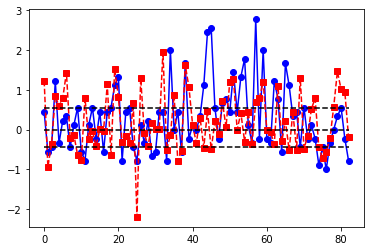

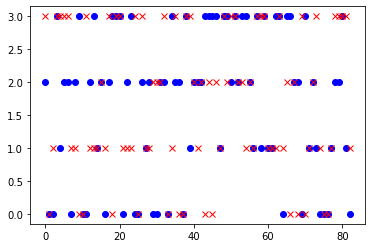

39.75903614457831 %


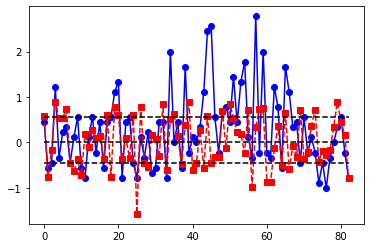

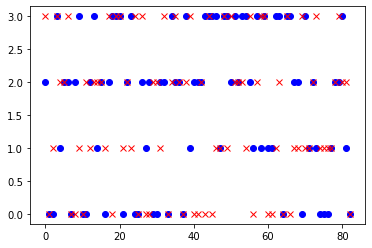

31.32530120481928 %


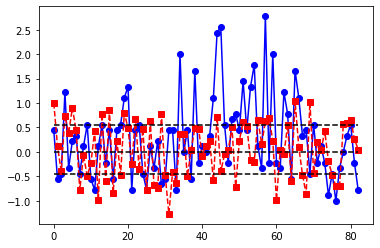

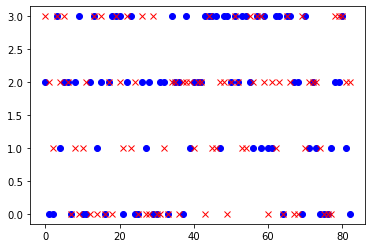

28.915662650602407 %


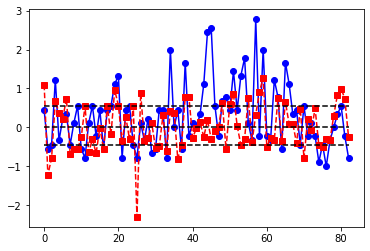

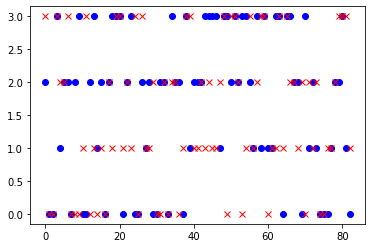

38.55421686746988 %


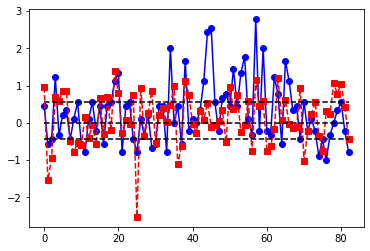

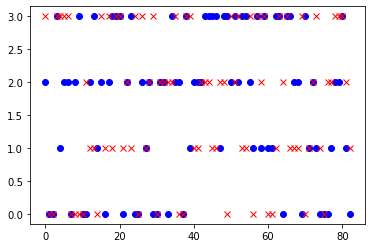

30.120481927710845 %


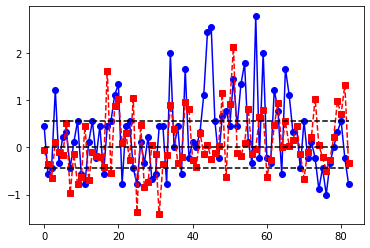

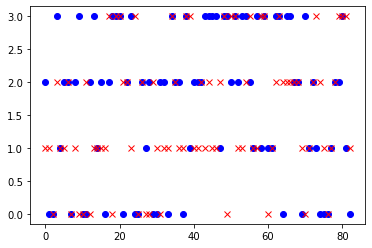

34.93975903614458 %


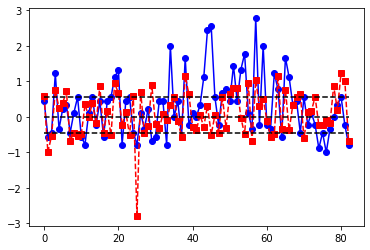

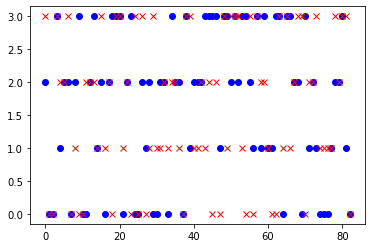

36.144578313253014 %


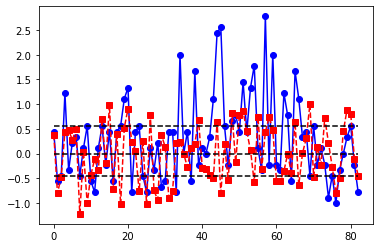

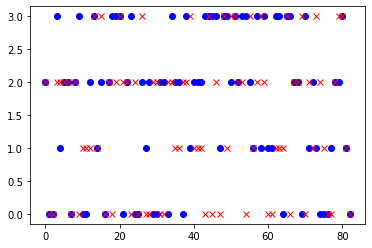

32.53012048192771 %


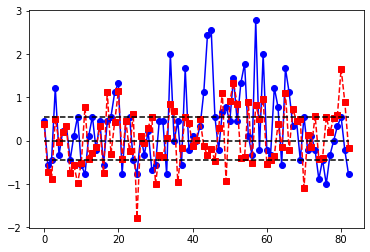

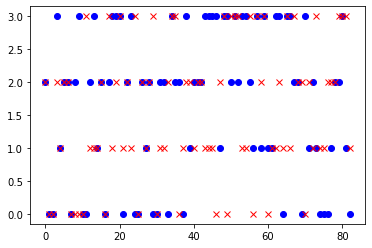

36.144578313253014 %


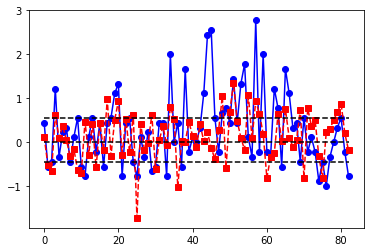

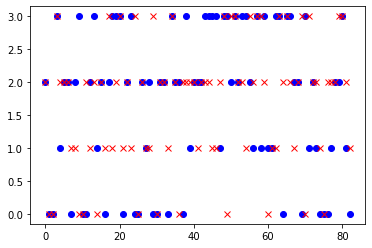

38.55421686746988 %


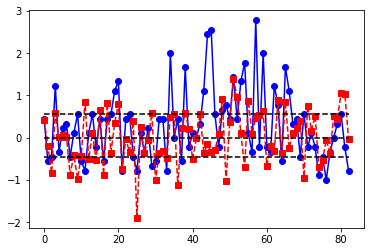

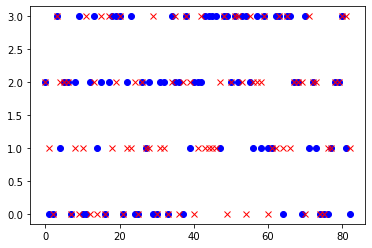

37.34939759036144 %


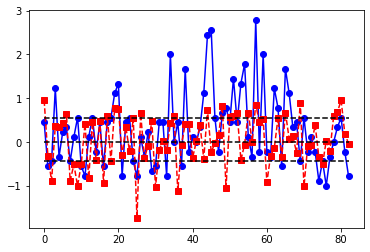

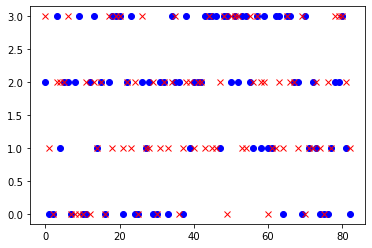

32.53012048192771 %


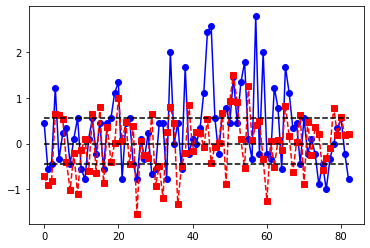

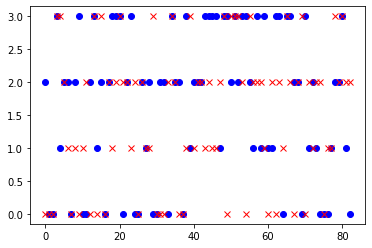

32.53012048192771 %


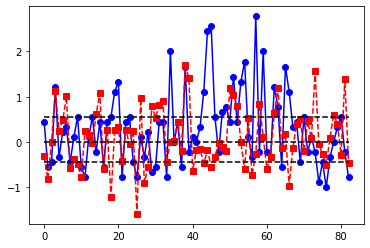

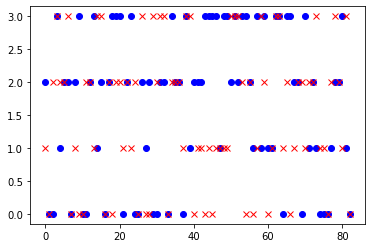

30.120481927710845 %


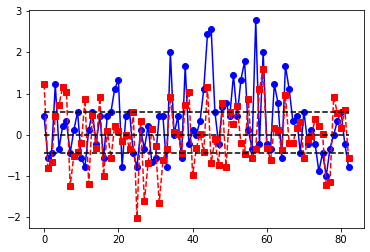

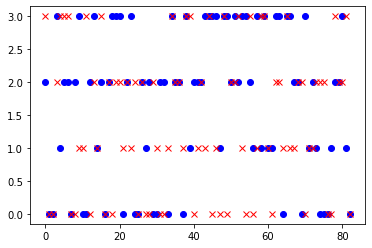

30.120481927710845 %


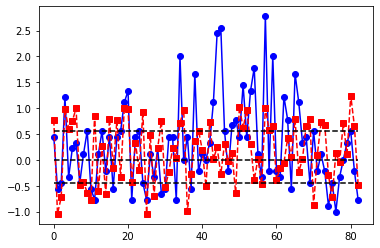

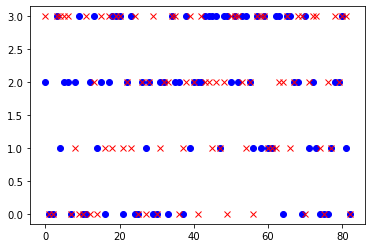

34.93975903614458 %


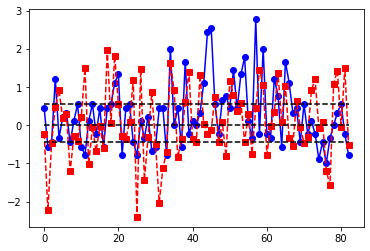

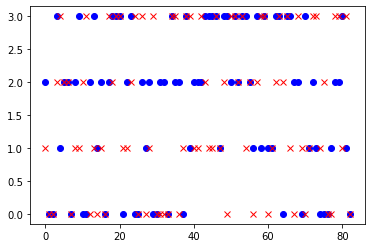

31.32530120481928 %


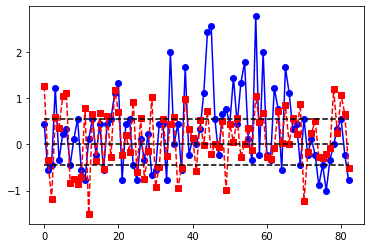

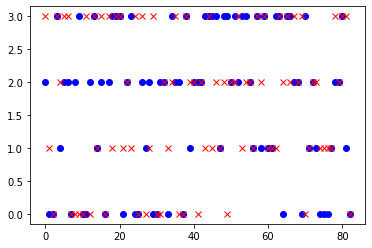

42.168674698795186 %


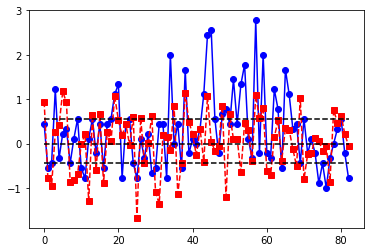

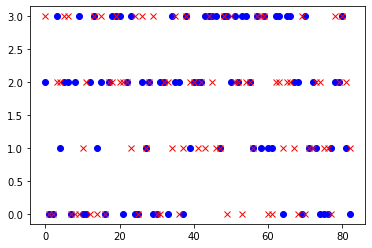

32.53012048192771 %


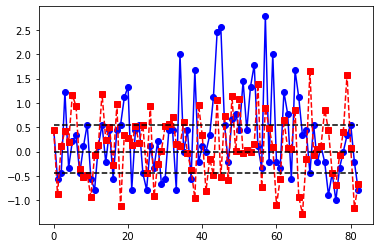

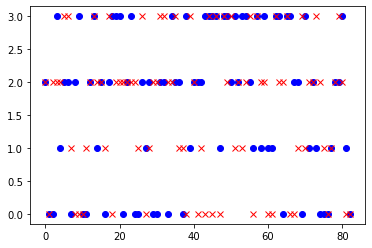

24.096385542168676 %


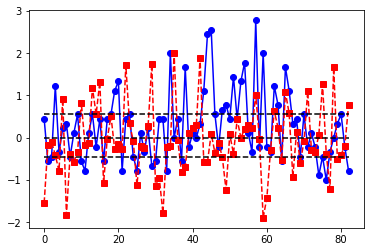

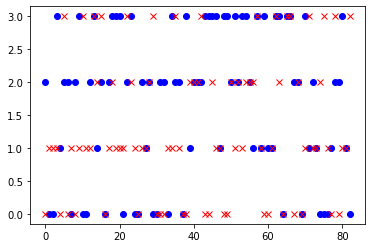

28.915662650602407 %


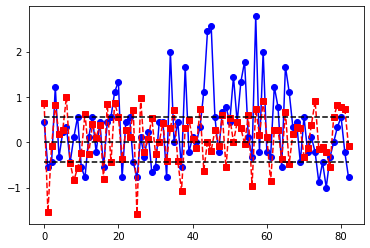

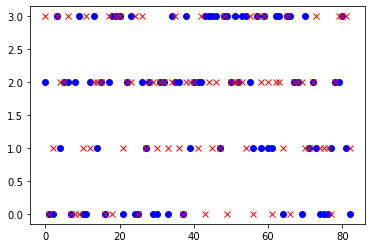

34.93975903614458 %


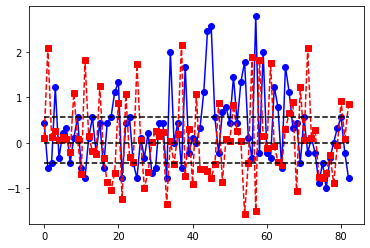

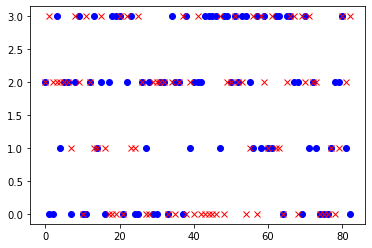

30.120481927710845 %


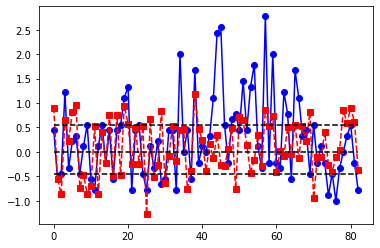

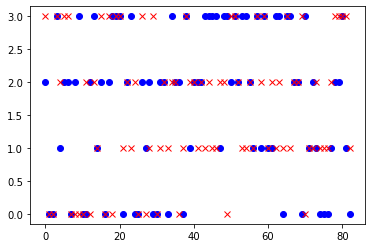

34.93975903614458 %


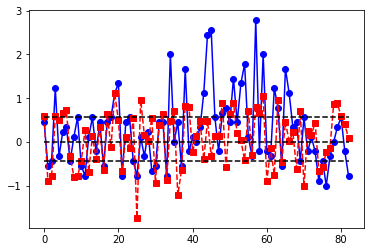

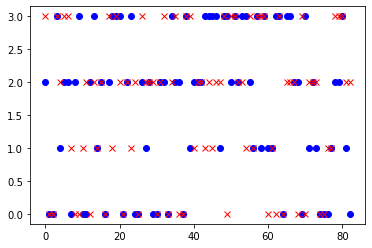

39.75903614457831 %


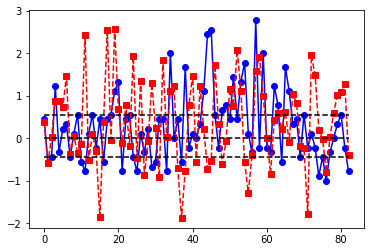

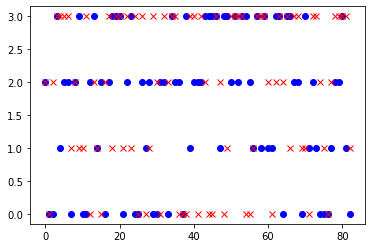

24.096385542168676 %


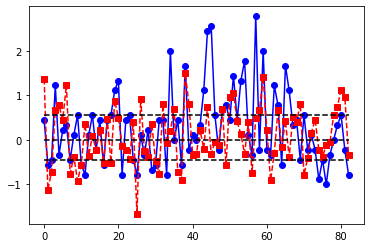

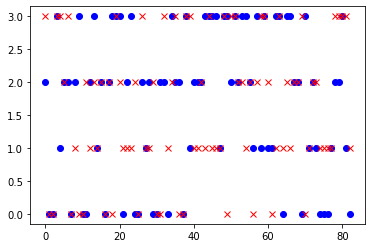

37.34939759036144 %


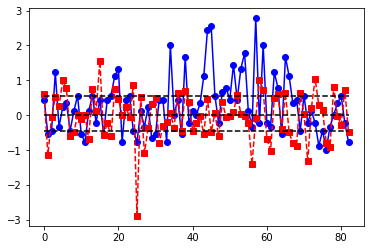

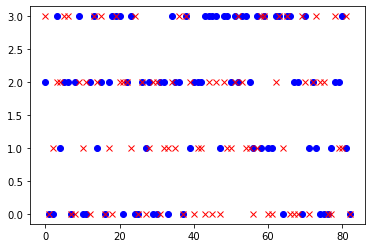

19.27710843373494 %


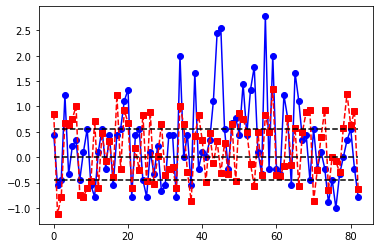

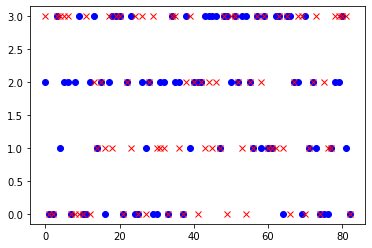

44.57831325301205 %


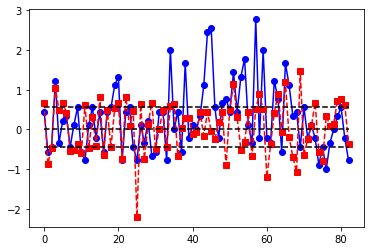

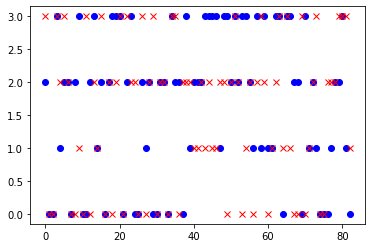

38.55421686746988 %


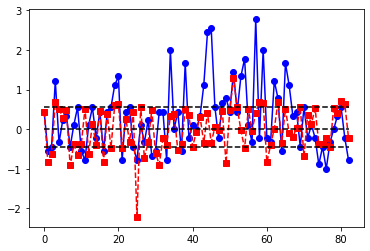

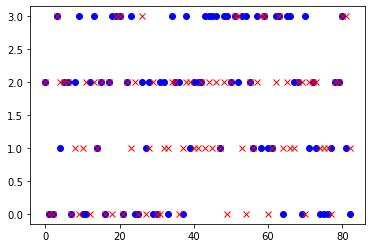

38.55421686746988 %


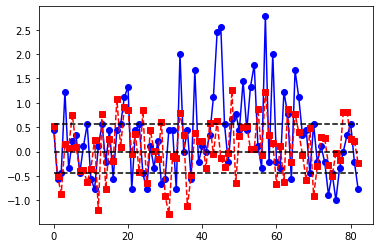

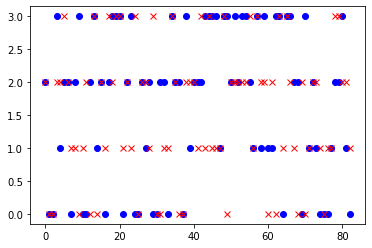

34.93975903614458 %


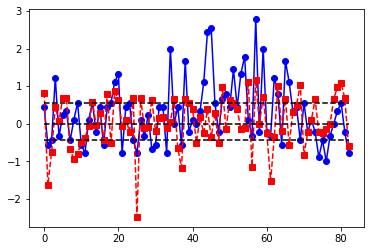

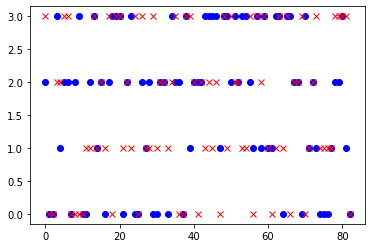

38.55421686746988 %


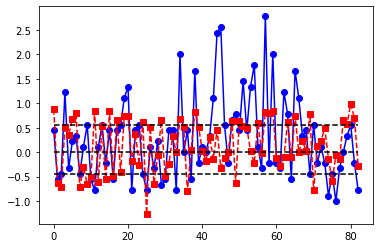

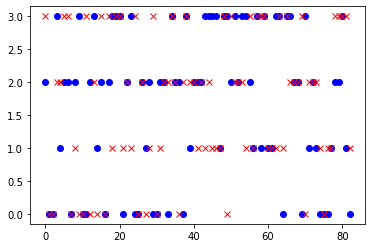

39.75903614457831 %


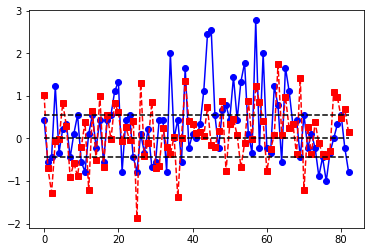

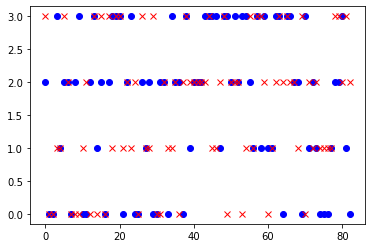

36.144578313253014 %


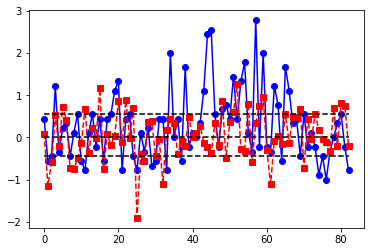

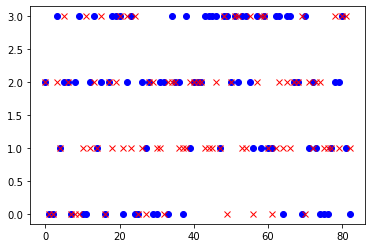

31.32530120481928 %


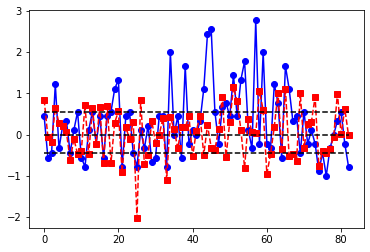

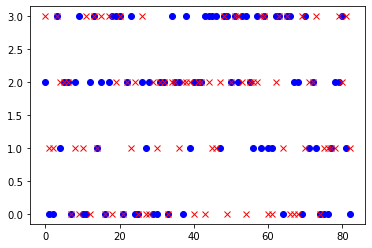

32.53012048192771 %


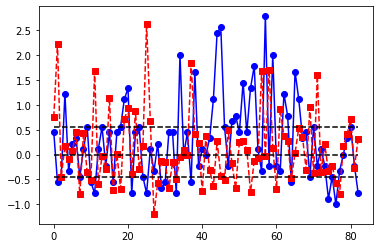

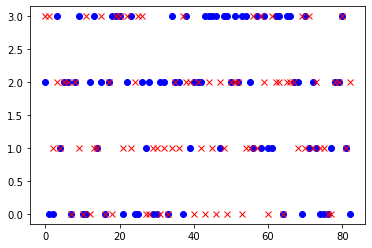

27.710843373493976 %


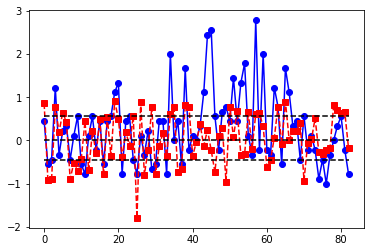

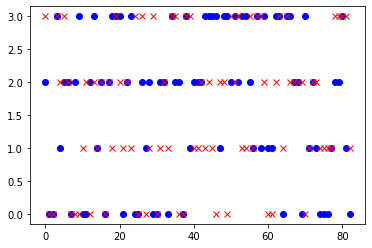

33.734939759036145 %


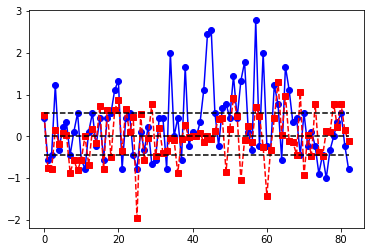

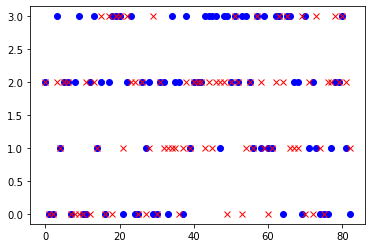

38.55421686746988 %


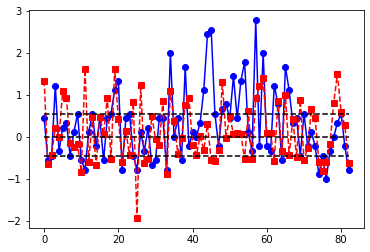

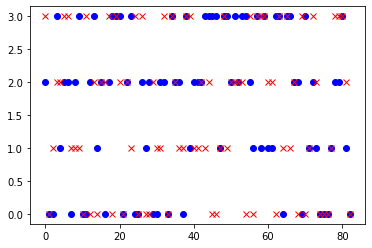

33.734939759036145 %


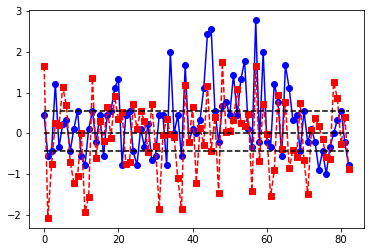

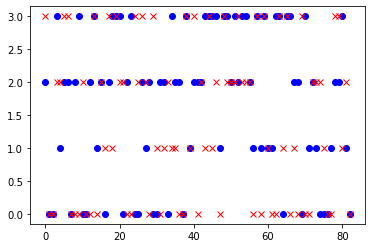

27.710843373493976 %


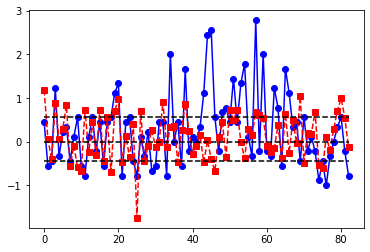

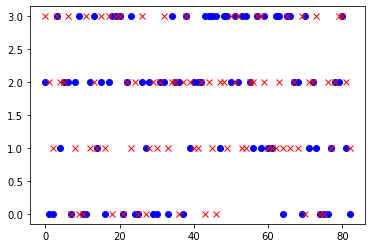

31.32530120481928 %


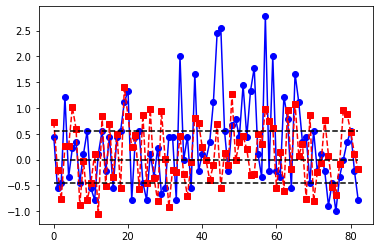

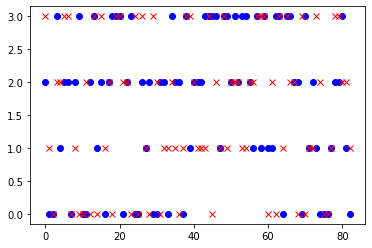

32.53012048192771 %


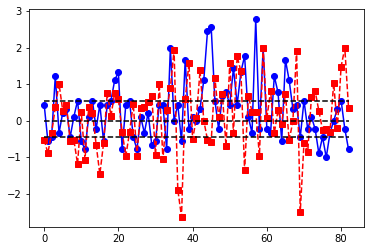

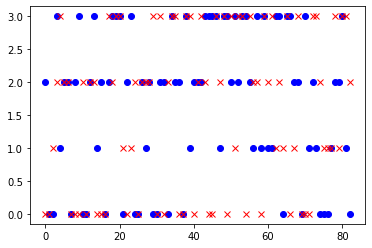

30.120481927710845 %


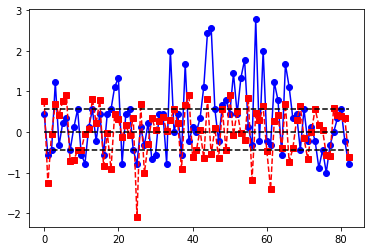

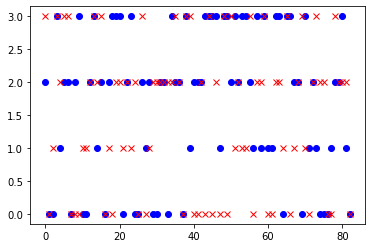

28.915662650602407 %


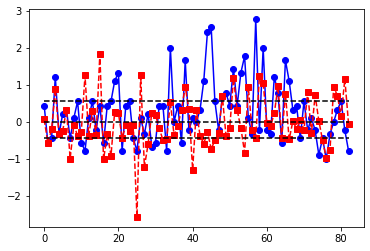

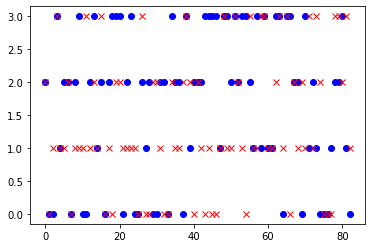

30.120481927710845 %


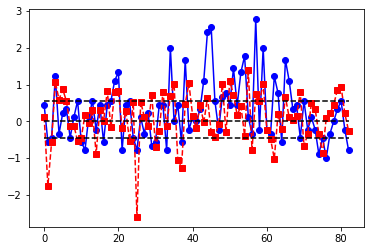

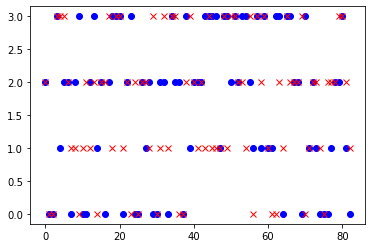

38.55421686746988 %


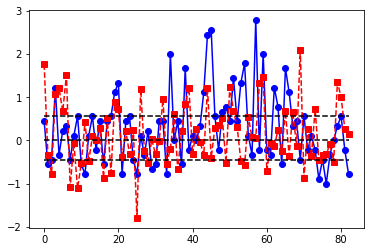

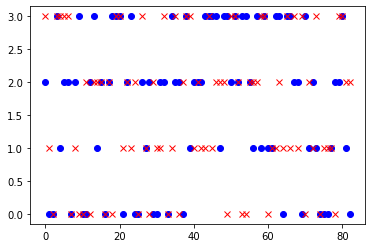

30.120481927710845 %


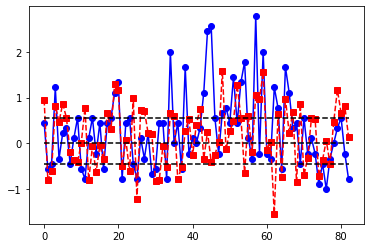

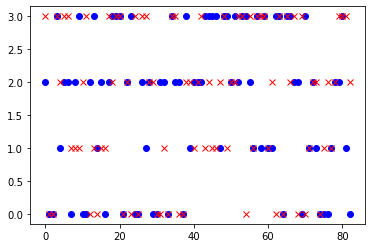

36.144578313253014 %


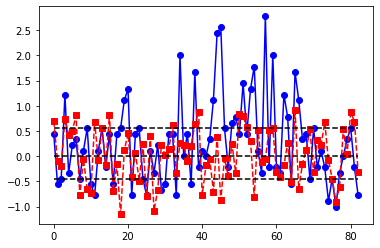

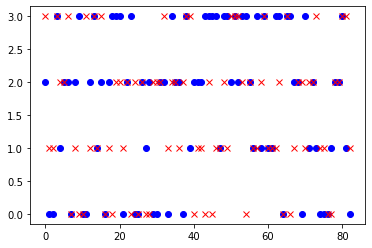

33.734939759036145 %


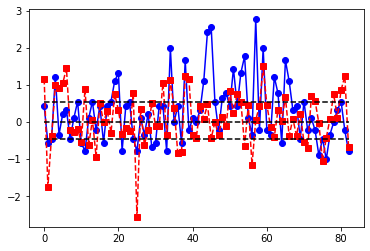

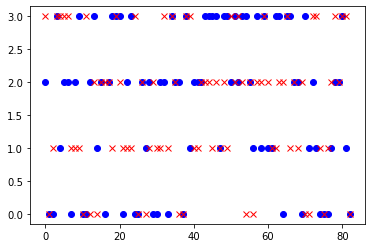

27.710843373493976 %


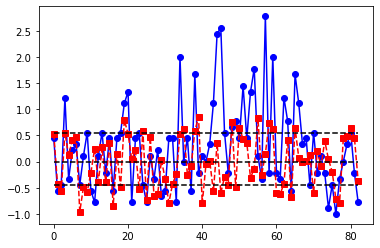

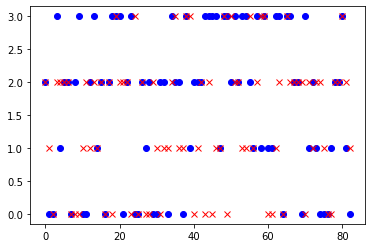

33.734939759036145 %


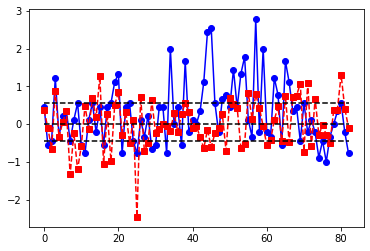

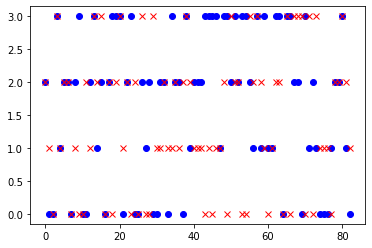

31.32530120481928 %


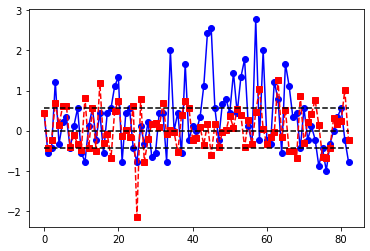

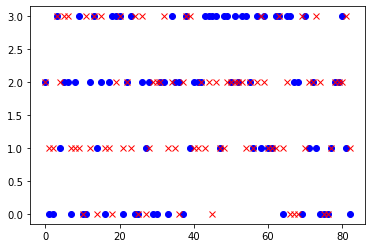

28.915662650602407 %


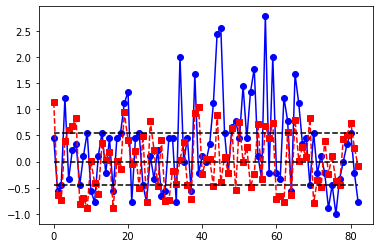

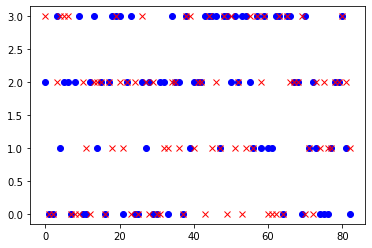

38.55421686746988 %


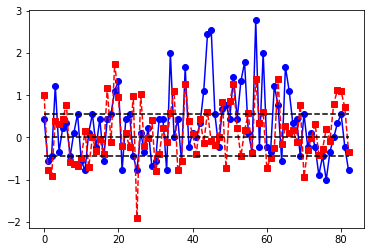

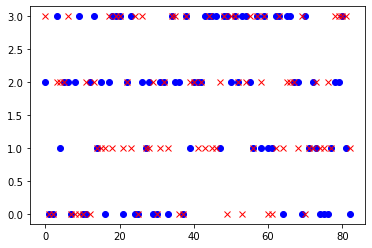

36.144578313253014 %


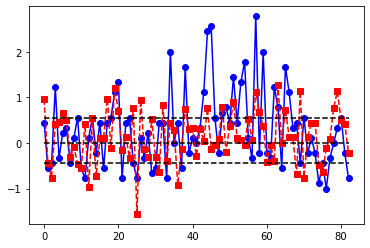

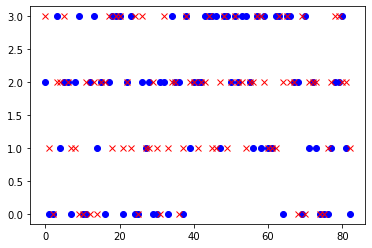

33.734939759036145 %


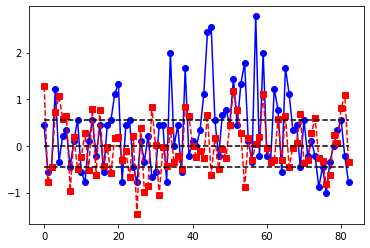

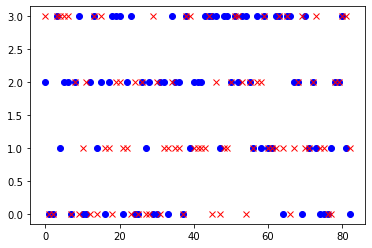

32.53012048192771 %


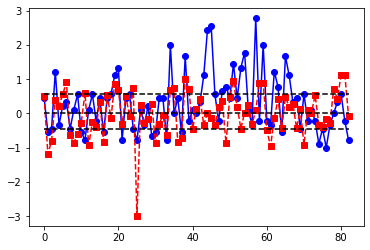

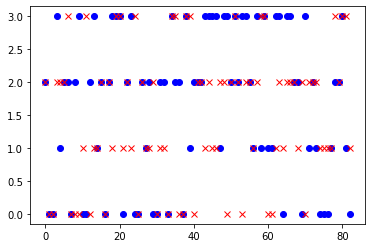

39.75903614457831 %


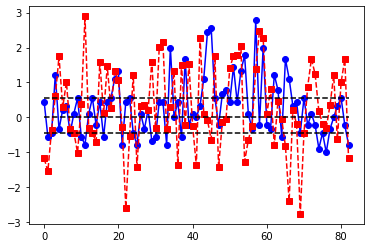

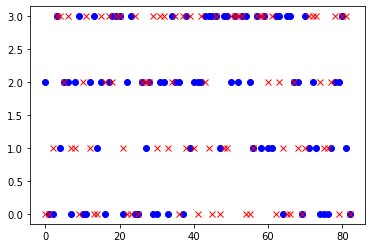

21.686746987951807 %


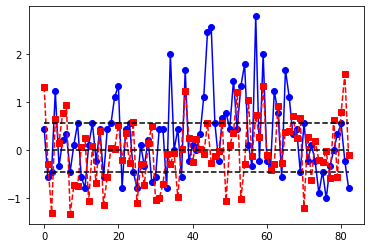

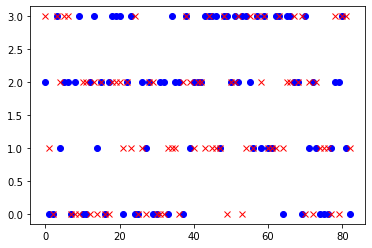

28.915662650602407 %


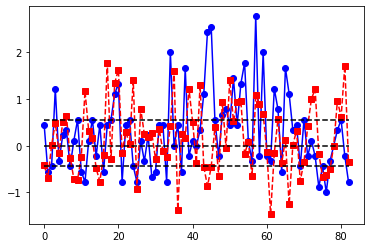

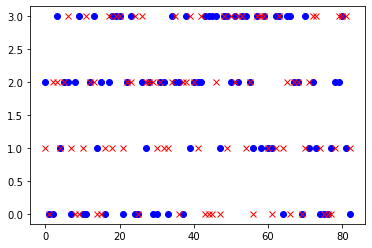

28.915662650602407 %


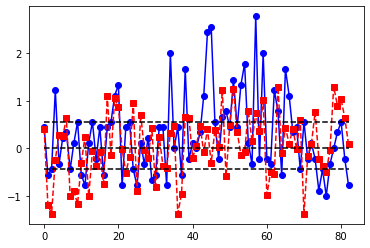

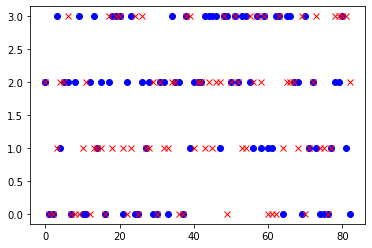

37.34939759036144 %


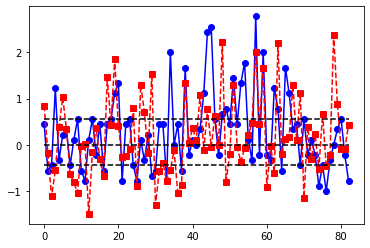

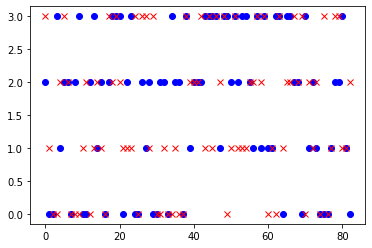

31.32530120481928 %


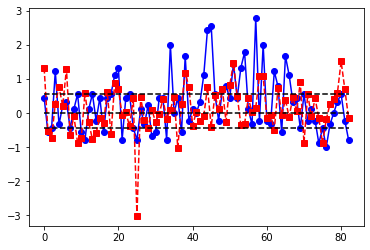

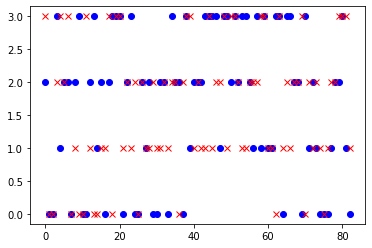

34.93975903614458 %


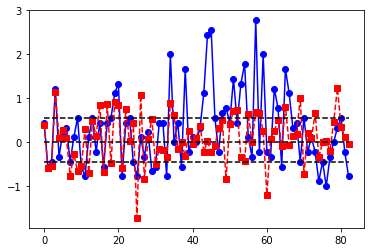

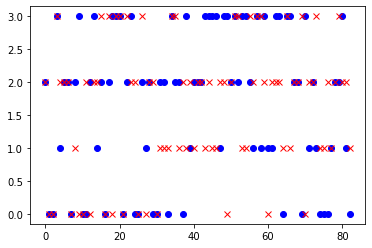

32.53012048192771 %


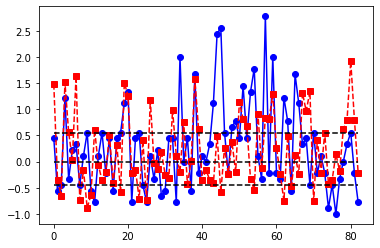

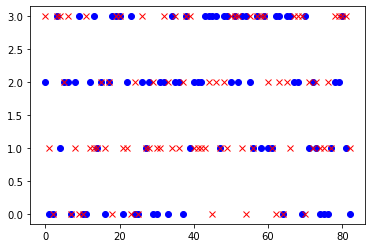

26.506024096385545 %


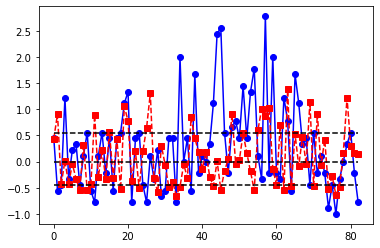

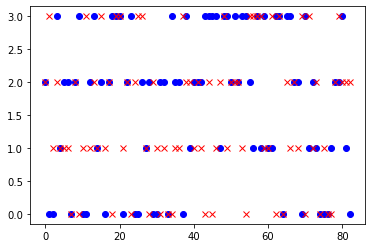

27.710843373493976 %


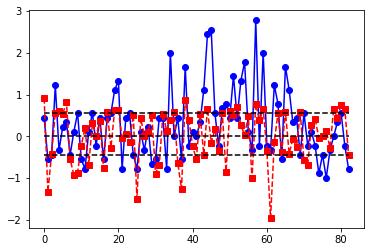

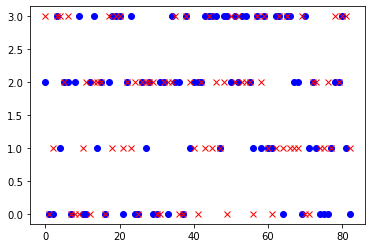

34.93975903614458 %


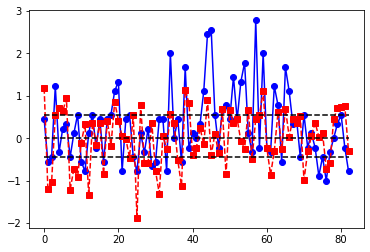

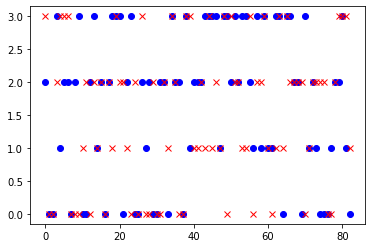

37.34939759036144 %


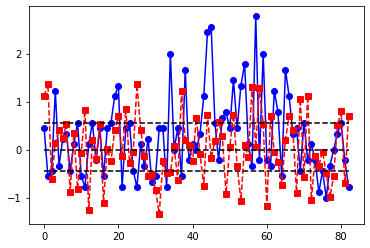

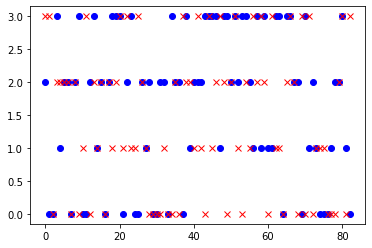

31.32530120481928 %


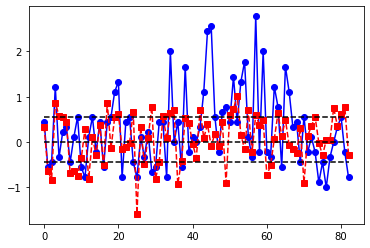

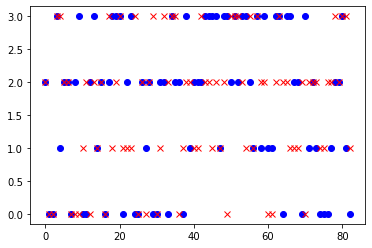

28.915662650602407 %


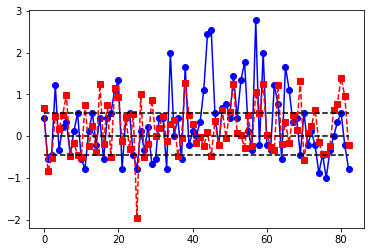

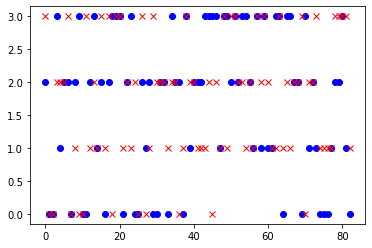

36.144578313253014 %


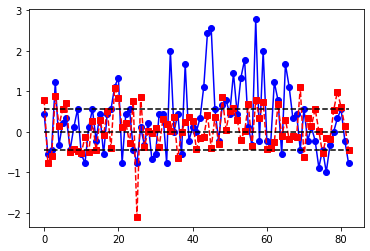

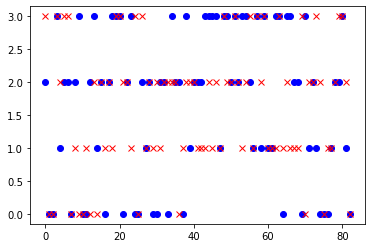

39.75903614457831 %


In [136]:
inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
targets = torch.autograd.Variable(torch.Tensor(y_test_scaled.astype(np.float32).squeeze()).float())

out = dict()
output_all = torch.zeros(targets.shape[0], Nnets)


n=0

acc_indiv = np.zeros(Nnets)

r_indiv = np.zeros(Nnets)

classTargetIndiv = np.zeros((targets.shape[0], Nnets))
classOutIndiv = np.zeros((targets.shape[0], Nnets))


trainValiData = np.vstack((y_train_scaled, y_vali_scaled))
for i in range(Nnets):
    # Transformando o dado de teste
    nets[i].eval()
    # Avaliando a acurácia do modelo utilizando os dados de teste transformados
    
    out[i] = nets[i](inputs)[-1] 
    
    classTargetIndiv[:,i] = np.digitize(targets, np.quantile(trainValiData,[0.25,0.5,0.75]))
    classOutIndiv[:,i] = np.digitize(out[i].detach().numpy().squeeze(), np.quantile(trainValiData,[0.25,0.5,0.75]))

    
    acc_indiv[i] = np.sum(classTargetIndiv[:,i].squeeze()==classOutIndiv[:,i].squeeze())/len(targets)*100
    r_indiv[i] = np.corrcoef(out[i].detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]
    
    
    

    output_all[:,[i]] = out[i]
    
    
    
#     classTarget = np.digitize(targets, np.quantile(trainValiData, [0.25,0.5,0.75])) 
#     classOut = np.digitize(output_all.detach().numpy(), np.quantile(trainValiData,[0.25,0.5,0.75]))
    
#     acc_all[i] = np.sum(classTarget.squeeze()==classOut.squeeze())/len(targets)*100
#     r_all[i] = np.corrcoef(output_all.detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]
    
    
    if best_acc[i] > 30:
        if n==0: 
            output_selec = out[i]
            n = n+1
        else:
            output_selec = torch.cat((output_selec, out[i]), dim=1)
            n = n+1
        
            
    
       
#     classTarget = np.digitize(targets, np.quantile(trainValiData,[0.25,0.5,0.75])) 
#     classOut = np.digitize(output_selec.detach().numpy().squeeze(), np.quantile(trainValiData,[0.25,0.5,0.75]))
    
#     acc_selec[i] = np.sum(classTarget.squeeze()==classOut.squeeze())/len(targets)*100
#     r_selec[i] = np.corrcoef(output_selec.detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]

    
 
for j in range(Nnets):
    if best_acc[j] > 30:
        plt.figure()
        plt.plot(targets, '-ob')
        plt.plot(out[j].detach().numpy(), '--sr')
        plt.plot(np.tile(np.quantile(y_train_scaled,[0.25,0.5,0.75]), (len(targets),1)), '--k')
        plt.show()
        
        
        plt.figure()
        plt.plot(classTargetIndiv[:,j], 'ob')
        plt.plot(classOutIndiv[:,j], 'xr')
        plt.show()
        print(acc_indiv[j], '%')

75


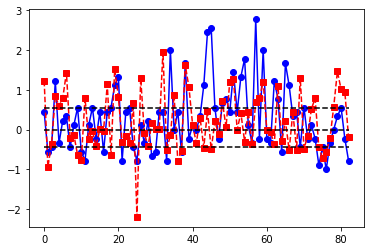

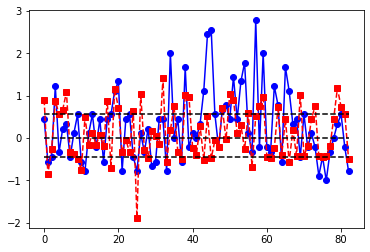

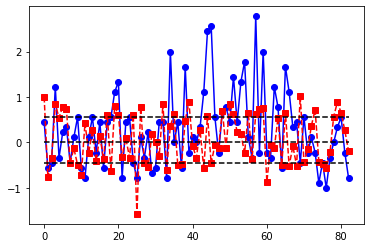

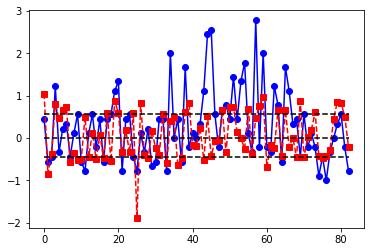

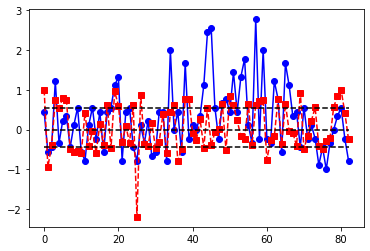

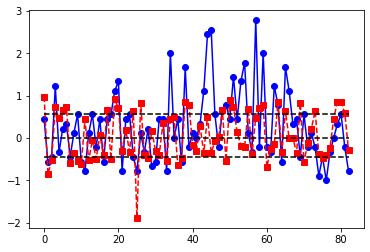

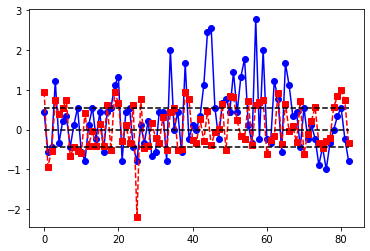

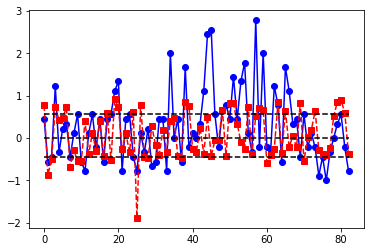

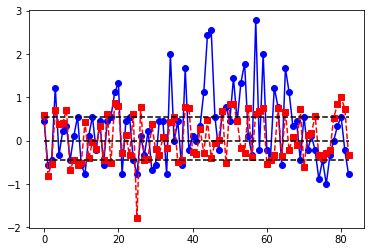

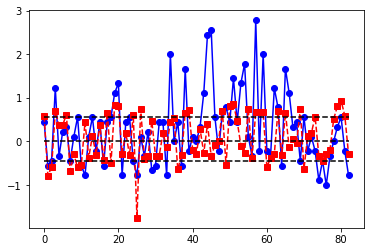

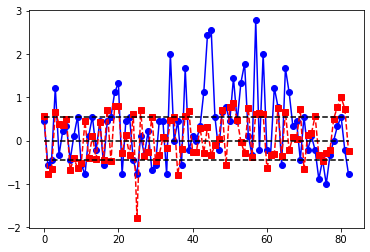

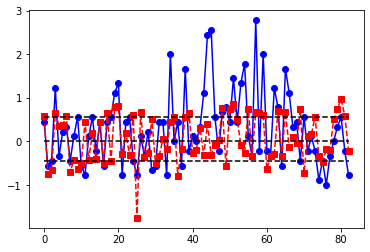

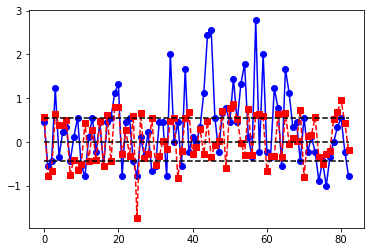

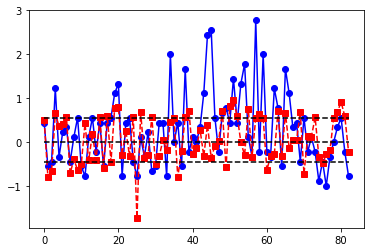

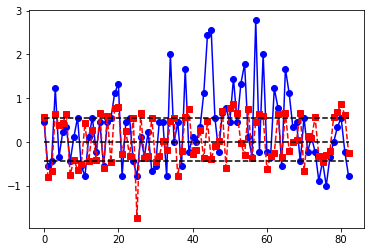

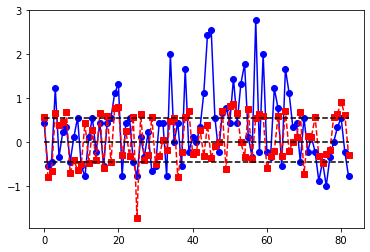

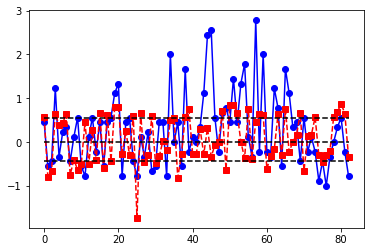

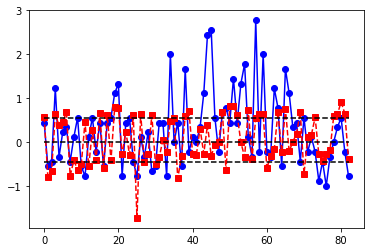

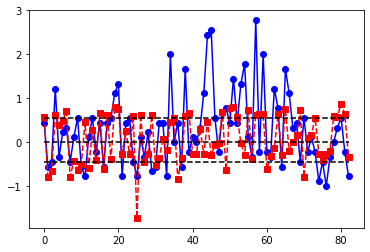

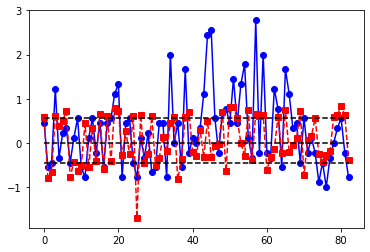

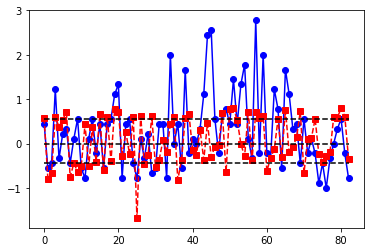

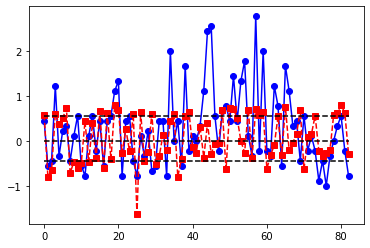

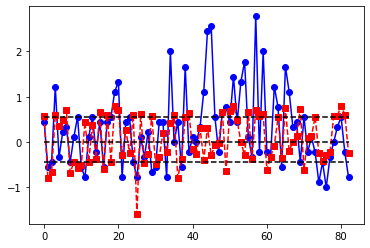

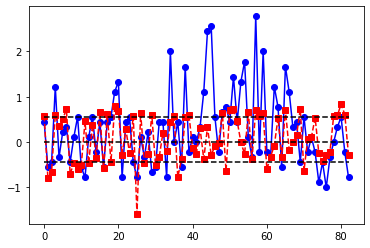

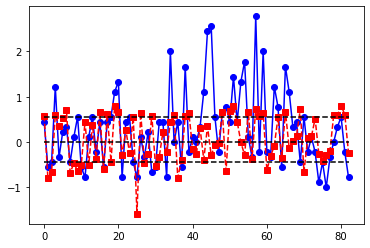

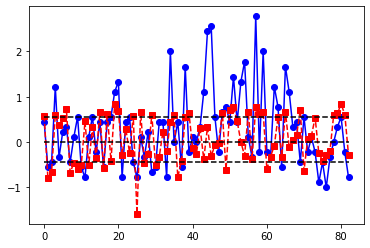

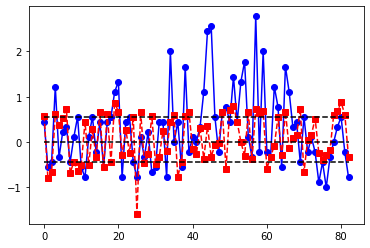

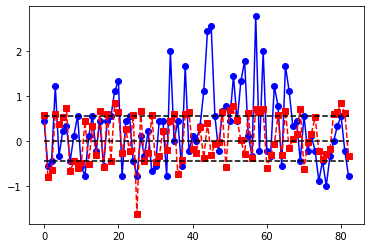

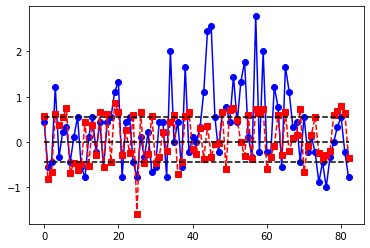

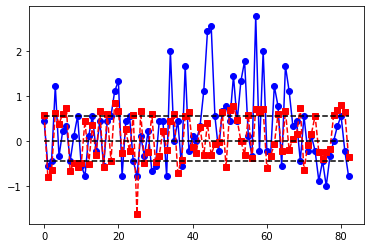

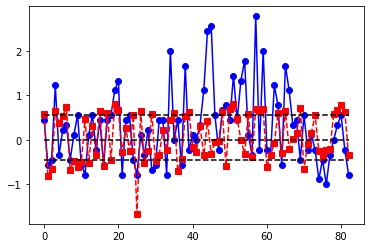

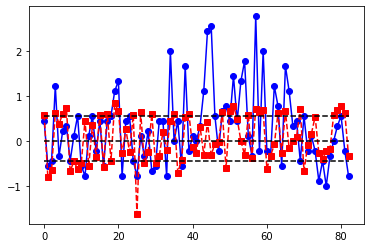

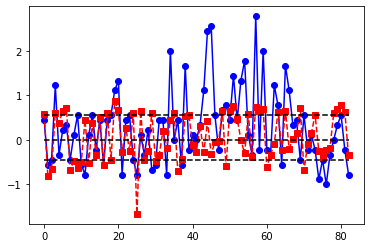

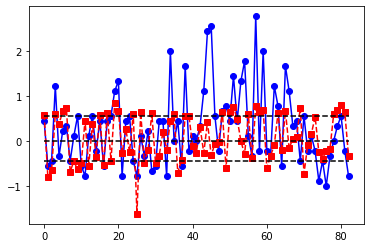

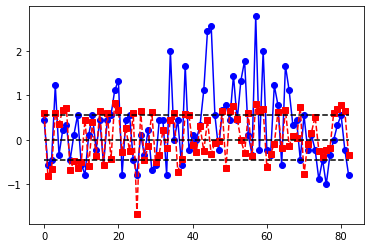

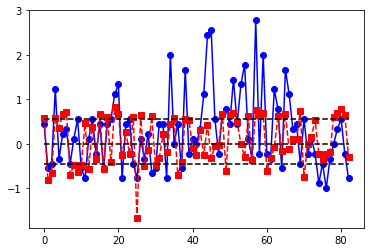

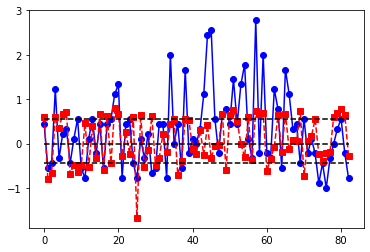

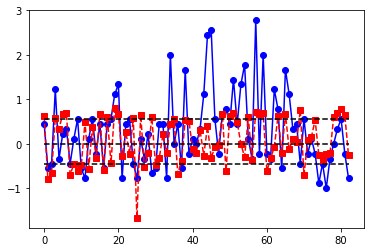

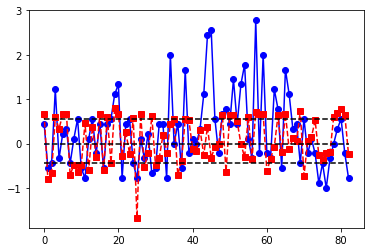

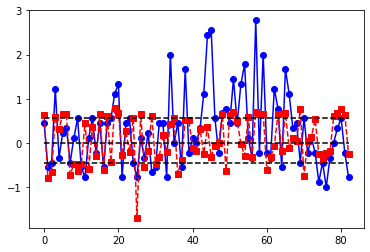

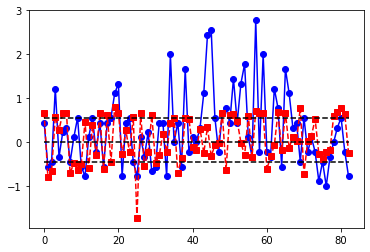

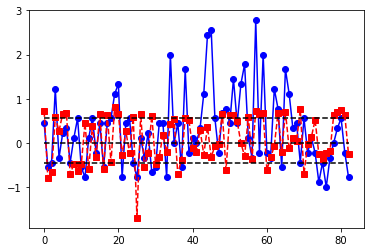

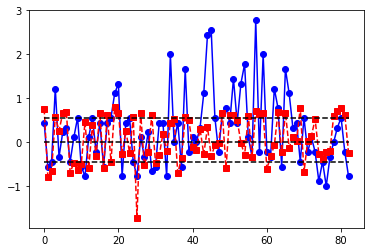

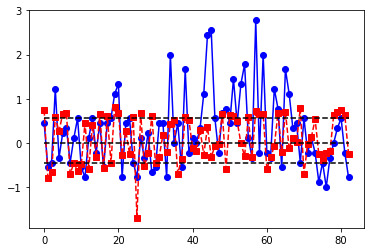

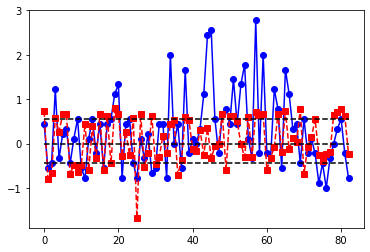

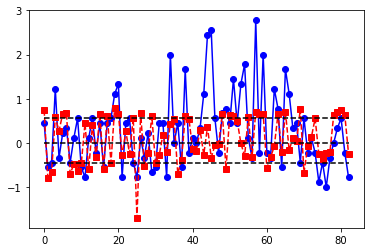

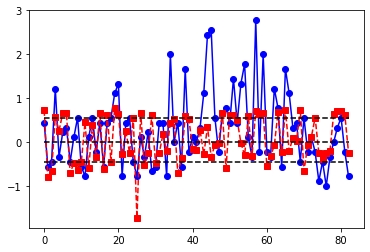

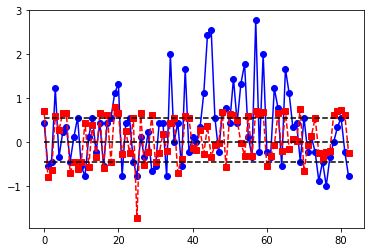

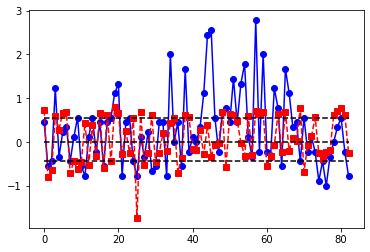

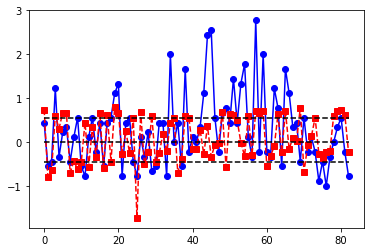

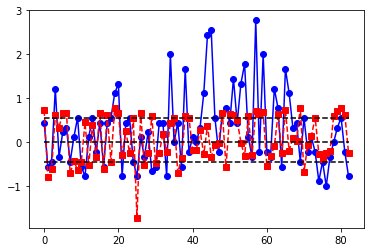

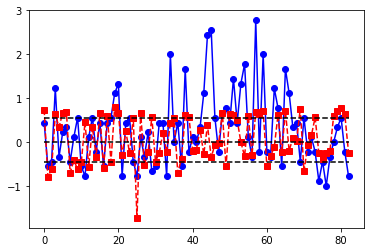

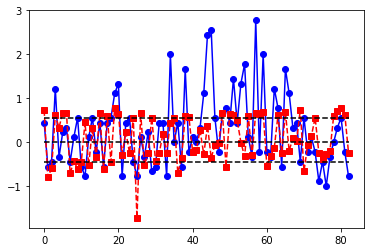

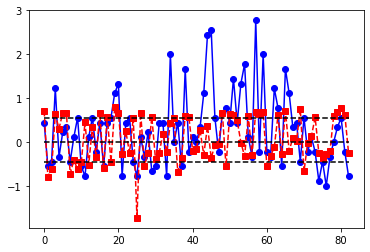

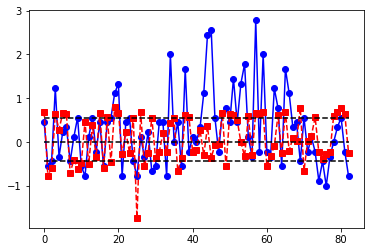

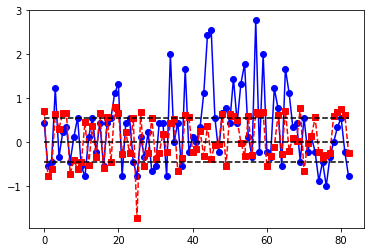

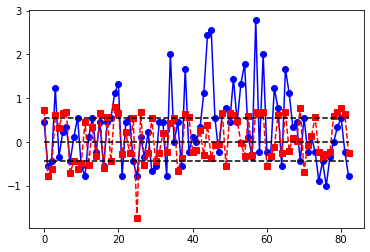

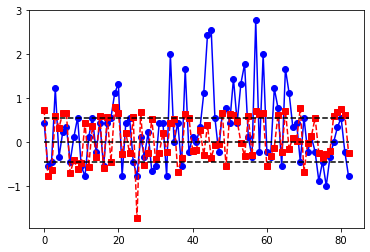

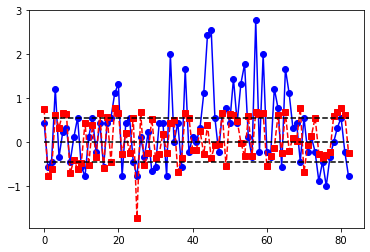

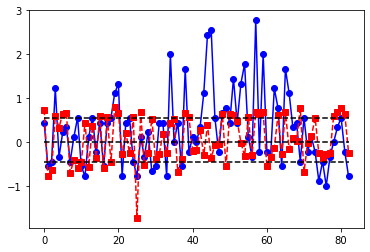

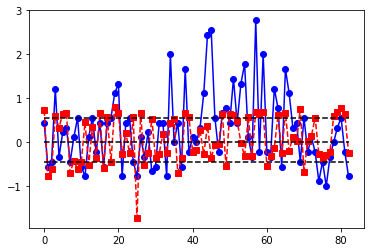

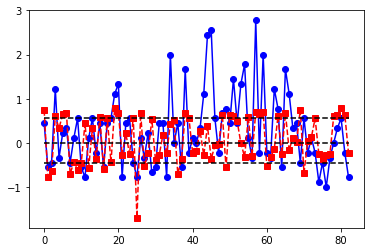

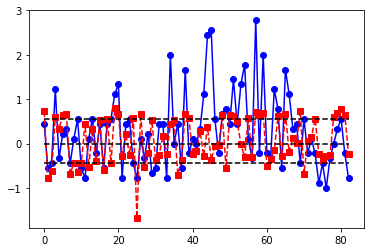

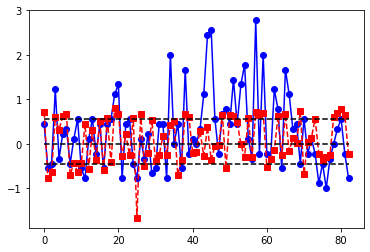

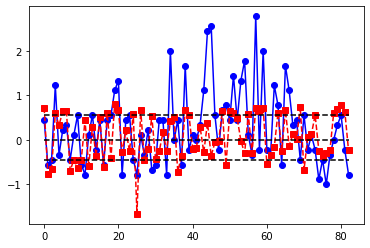

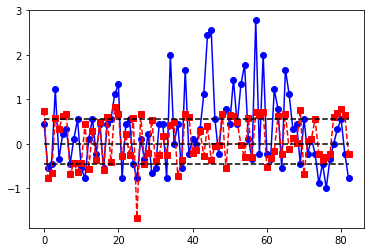

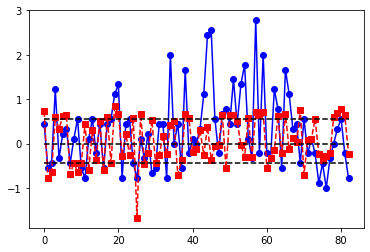

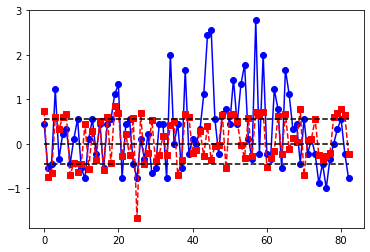

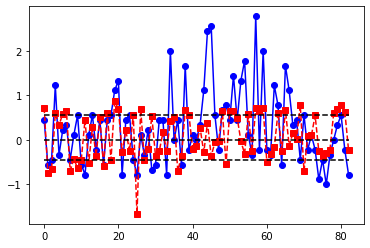

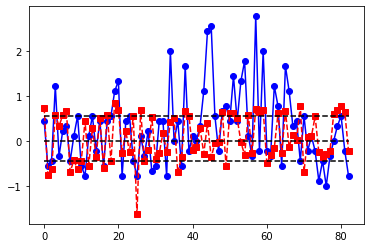

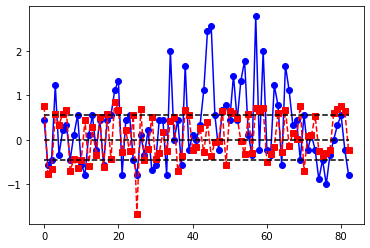

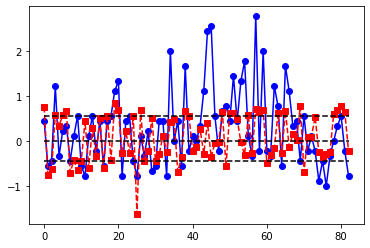

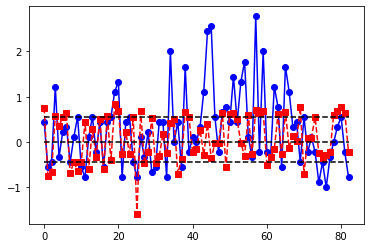

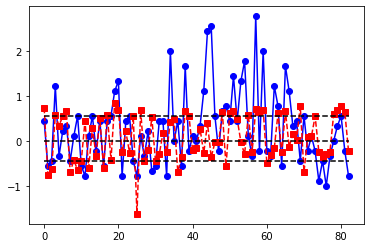

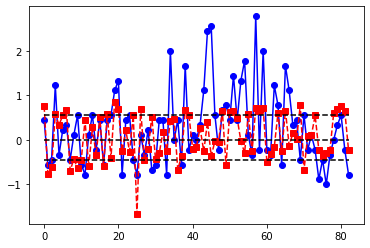

In [132]:
acc_all = np.zeros(Nnets)
acc_selec = np.zeros(output_selec.shape[1])

r_all = np.zeros(Nnets)
r_selec = np.zeros(output_selec.shape[1])

output_allmedian=np.zeros_like(output_all.detach().numpy())
output_selecmedian=np.zeros_like(output_selec.detach().numpy())

for i in range(0,Nnets):    
    output_allmedian[:,[i]] = np.median(output_all[:,:i+1].detach().numpy(), axis=1, keepdims=True)
    classTarget = np.digitize(targets, np.quantile(trainValiData, [0.25,0.5,0.75])) 
    classOut = np.digitize(output_allmedian[:,[i]], np.quantile(trainValiData,[0.25,0.5,0.75]))
    
    acc_all[i] = np.sum(classTarget.squeeze()==classOut.squeeze())/len(targets)*100
    r_all[i] = np.corrcoef(output_allmedian[:,i], targets.detach().numpy().squeeze())[0,1]


print(output_selec.shape[1])
for i in range(output_selec.shape[1]):
    output_selecmedian[:,[i]] = np.median(output_selec[:,:i+1].detach().numpy(), axis=1, keepdims=True)
    plt.figure()
    plt.plot(targets, '-ob')
    plt.plot(output_selecmedian[:,[i]], '--sr')
    plt.plot(np.tile(np.quantile(trainValiData,[0.25,0.5,0.75]), (len(targets),1)), '--k')
    plt.show()     
    
    classTarget = np.digitize(targets, np.quantile(trainValiData, [0.25,0.5,0.75])) 
    classOut = np.digitize(output_selecmedian[:,[i]], np.quantile(trainValiData,[0.25,0.5,0.75]))
    
    acc_selec[i] = np.sum(classTarget.squeeze()==classOut.squeeze())/len(targets)*100
    r_selec[i] = np.corrcoef(output_selecmedian[:,i], targets.detach().numpy().squeeze())[0,1]
    
   
        
            
    
       
#     classTarget = np.digitize(targets, np.quantile(trainValiData,[0.25,0.5,0.75])) 
#     classOut = np.digitize(output_selec.detach().numpy().squeeze(), np.quantile(trainValiData,[0.25,0.5,0.75]))
    
#     acc_selec[i] = np.sum(classTarget.squeeze()==classOut.squeeze())/len(targets)*100
#     r_selec[i] = np.corrcoef(output_selec.detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]


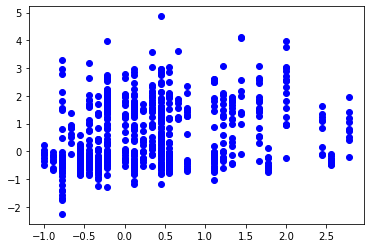

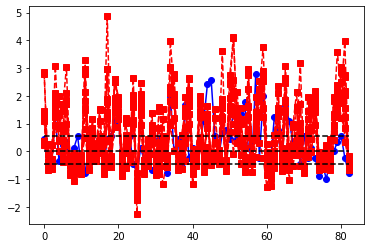

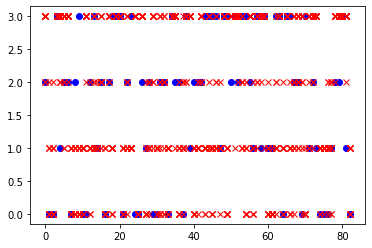

IndexError: index 1999 is out of bounds for axis 0 with size 9

In [112]:
            
plt.figure()
plt.plot(targets, output_selec.detach().numpy(), 'ob')
plt.show()

plt.figure()
plt.plot(targets, '-ob')
plt.plot(output_selec.detach().numpy(), '--sr')
plt.plot(np.tile(np.quantile(y_train_scaled,[0.25,0.5,0.75]), (len(targets),1)), '--k')
plt.show()

plt.figure()
plt.plot(np.digitize(targets, np.quantile(y_train_scaled,[0.25,0.5,0.75])), 'ob')
plt.plot(np.digitize(output_selec.detach().numpy().squeeze(), np.quantile(y_train_scaled,[0.25,0.5,0.75])), 'xr')
plt.show()

print('Accuracy', acc_selec[Nnets-1], '%')

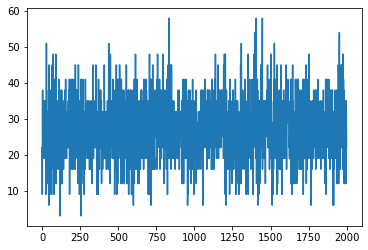

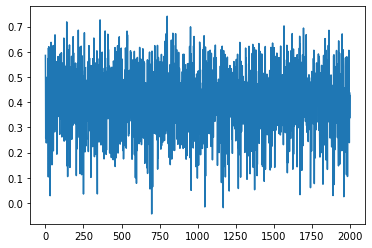

9

In [113]:
plt.figure()
plt.plot(best_acc)
plt.show()

plt.figure()
plt.plot(best_r)
plt.show()
(best_acc>50).sum()

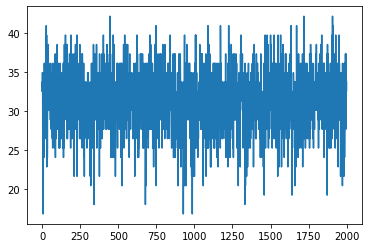

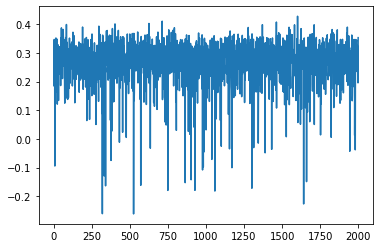

In [114]:
plt.figure()
plt.plot(acc_indiv)
plt.show()

plt.figure()
plt.plot(r_indiv)
plt.show()


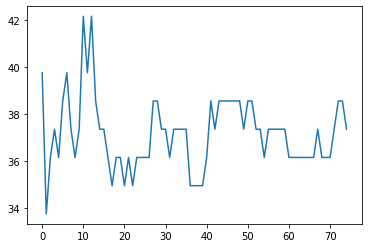

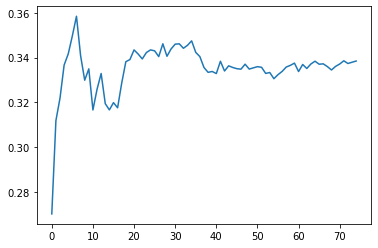

In [133]:
plt.figure()
plt.plot(acc_selec)
plt.show()

plt.figure()
plt.plot(r_selec)
plt.show()

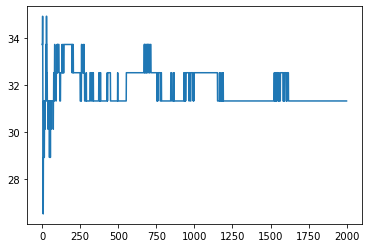

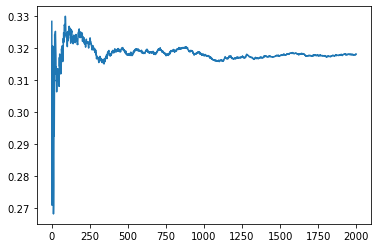

In [80]:
plt.figure()
plt.plot(acc_all)
plt.show()

plt.figure()
plt.plot(r_all)
plt.show()

In [ ]:
out = nets[np.argmax(acc_indiv)](inputs)[-1] 
    
classTarget = np.digitize(targets, np.quantile(y_train_scaled,[0.25,0.5,0.75])) 
classOut = np.digitize(out.detach().numpy(), np.quantile(y_train_scaled,[0.25,0.5,0.75]))

plt.figure()
plt.plot(targets, '-ob')
plt.plot(out.detach().numpy(), '--sr')
plt.plot(np.tile(np.quantile(y_train_scaled,[0.25,0.5,0.75]), (len(targets),1)), '--k')
plt.show()

plt.figure()
plt.plot(classTarget, 'ob')
plt.plot(classOut, 'xr')
plt.show()

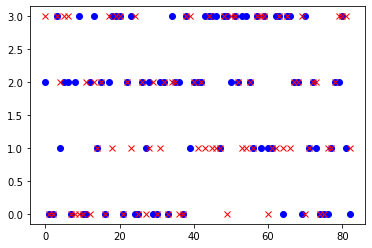

Acurácia 51.80722891566265 %


In [274]:
# classOutSelec=classOutIndiv[:, best_acc>25]
voteClassOut, _ = mode(classOutSelec[:,[0, 1,2,4,13,19, 24,33]], axis=1)
plt.figure()
plt.plot(classTarget, 'ob')
plt.plot(voteClassOut, 'xr')
plt.show()
print('Acurácia', np.sum(classTarget.squeeze()==voteClassOut.squeeze())/len(targets)*100, '%')

In [147]:
classOutIndiv[:, best_acc>30].shape

(83, 75)

In [258]:
C = confusion_matrix(classOutSelec[:,13], classTarget)
C = C/np.sum(C, axis=1, keepdims=True)*100
C

array([[53.33333333, 13.33333333, 13.33333333, 20.        ],
       [29.16666667, 16.66666667, 16.66666667, 37.5       ],
       [ 9.09090909, 22.72727273, 40.90909091, 27.27272727],
       [ 9.09090909,  9.09090909, 45.45454545, 36.36363636]])

In [277]:
classOutSelec.shape

(83, 323)

In [ ]:
 best_acc>25